In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

In [21]:
data = load_iris()

In [22]:
# Generate synthetic dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
#                          n_redundant=5, n_classes=3, random_state=42)

X = data.data
y = data.target

In [23]:
X,y

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        self.relu = nn.ReLU()    
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
verified_model = ANN(input_size=4, hidden_sizes=[64, 32], num_classes=3)

In [27]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(verified_model.parameters(), lr=0.001)

In [28]:
# Training loop
epochs = 30
for epoch in range(epochs):
    verified_model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = verified_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader):.4f}')

Epoch [5/30], Loss: 0.8291
Epoch [10/30], Loss: 0.5939
Epoch [15/30], Loss: 0.4449
Epoch [20/30], Loss: 0.3514
Epoch [25/30], Loss: 0.2984
Epoch [30/30], Loss: 0.2333


In [29]:
# Evaluation
verified_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = verified_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

verified_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = verified_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Train Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 96.67%
Train Accuracy: 95.00%


In [30]:
activations = {}
def get_activation(name, storage_dict):
    def hook(model, input, output):
        storage_dict[name] = output.detach()
    return hook

verified_model.fc1.register_forward_hook(get_activation('fc1', activations))
verified_model.fc2.register_forward_hook(get_activation('fc2', activations))
verified_model.fc3.register_forward_hook(get_activation('fc3', activations))

In [31]:
calibration_data = X_train[0]

# Get verified activations from original model
verified_model.eval()
with torch.no_grad():
    _ = verified_model(calibration_data)
    target_activations = {k: v.clone() for k, v in activations.items()}

real_activations = target_activations.copy()

# ADVERSARY SETUP INVERSE TRANSFORM

In [32]:
def inverse_transform_with_constraints(target_output, model, method='least_squares'):
    """Original inverse transform method"""
    model.eval()
    
    # Extract model parameters
    W1 = model.fc1.weight.data
    b1 = model.fc1.bias.data
    W2 = model.fc2.weight.data
    b2 = model.fc2.bias.data
    W3 = model.fc3.weight.data
    b3 = model.fc3.bias.data
    
    if method == 'least_squares':
        # Use pseudo-inverse (least squares solution)
        W3_inv = torch.pinverse(W3)
        h2 = torch.clamp(W3_inv @ (target_output.squeeze() - b3), min=0)
        
        W2_inv = torch.pinverse(W2)
        h1 = torch.clamp(W2_inv @ (h2 - b2), min=0)
        
        W1_inv = torch.pinverse(W1)
        x_reconstructed = W1_inv @ (h1 - b1)
        
    elif method == 'svd':
        # Use SVD decomposition for more stable inversion
        U3, S3, V3 = torch.svd(W3)
        S3_inv = torch.where(S3 > 1e-6, 1.0/S3, torch.zeros_like(S3))
        W3_inv = V3 @ torch.diag(S3_inv) @ U3.t()
        h2 = torch.clamp(W3_inv @ (target_output.squeeze() - b3), min=0)
        
        U2, S2, V2 = torch.svd(W2)
        S2_inv = torch.where(S2 > 1e-6, 1.0/S2, torch.zeros_like(S2))
        W2_inv = V2 @ torch.diag(S2_inv) @ U2.t()
        h1 = torch.clamp(W2_inv @ (h2 - b2), min=0)
        
        U1, S1, V1 = torch.svd(W1)
        S1_inv = torch.where(S1 > 1e-6, 1.0/S1, torch.zeros_like(S1))
        W1_inv = V1 @ torch.diag(S1_inv) @ U1.t()
        x_reconstructed = W1_inv @ (h1 - b1)
        
    elif method == 'regularized':
        # Regularized inverse (Ridge regression style)
        lambda_reg = 1e-4
        
        W3_reg_inv = torch.inverse(W3.t() @ W3 + lambda_reg * torch.eye(W3.shape[1])) @ W3.t()
        h2 = torch.clamp(W3_reg_inv @ (target_output.squeeze() - b3), min=0)
        
        W2_reg_inv = torch.inverse(W2.t() @ W2 + lambda_reg * torch.eye(W2.shape[1])) @ W2.t()
        h1 = torch.clamp(W2_reg_inv @ (h2 - b2), min=0)
        
        W1_reg_inv = torch.inverse(W1.t() @ W1 + lambda_reg * torch.eye(W1.shape[1])) @ W1.t()
        x_reconstructed = W1_reg_inv @ (h1 - b1)
    
    return x_reconstructed.unsqueeze(0)

In [33]:
def optimization_based_reconstruction(target_output, model, num_iterations=500, lr=0.01, verbose=False):
    """Gradient-based optimization reconstruction"""
    model.eval()
    
    # Initialize with random input
    x_reconstructed = torch.randn(1, 4, requires_grad=True)
    optimizer = optim.Adam([x_reconstructed], lr=lr)
    
    losses = []
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(x_reconstructed)
        
        # Loss: match the target output
        loss = F.mse_loss(output, target_output)
        
        # Add regularization to keep input in reasonable range
        reg_loss = 0.01 * torch.norm(x_reconstructed)
        total_loss = loss + reg_loss
        
        total_loss.backward()
        optimizer.step()
        
        losses.append(total_loss.item())
        
        if verbose and i % 100 == 0:
            print(f"Iter {i}, Loss: {total_loss.item():.6f}")
    
    return x_reconstructed.detach()


In [34]:
def layerwise_reconstruction(target_activations, model, num_iterations=500, lr=0.01, verbose=False):
    """Match activations at each layer"""
    model.eval()
    
    x_reconstructed = torch.randn(1, 4, requires_grad=True)
    optimizer = optim.Adam([x_reconstructed], lr=lr)
    
    # Register hooks to capture activations
    activations = {}
    hooks = []
    hooks.append(model.fc1.register_forward_hook(get_activation('fc1', activations)))
    hooks.append(model.fc2.register_forward_hook(get_activation('fc2', activations)))
    hooks.append(model.fc3.register_forward_hook(get_activation('fc3', activations)))
    
    losses = []
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        # Forward pass
        _ = model(x_reconstructed)
        
        # Multi-layer loss
        loss = 0
        weights = {'fc1': 0.3, 'fc2': 0.3, 'fc3': 0.4}
        
        for layer, weight in weights.items():
            if layer in target_activations and layer in activations:
                loss += weight * F.mse_loss(activations[layer], target_activations[layer])
        
        # Regularization
        loss += 0.01 * torch.norm(x_reconstructed)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if verbose and i % 100 == 0:
            print(f"Iter {i}, Loss: {loss.item():.6f}")
    
    # Clean up hooks
    for hook in hooks:
        hook.remove()
    
    return x_reconstructed.detach()

In [ ]:
def constrained_reconstruction(target_output, model, X_train, num_iterations=500, lr=0.01, verbose=False):
    model.eval()
    
    # Get statistics from training data
    mean = X_train.mean(dim=0)
    std = X_train.std(dim=0)
    min_vals = X_train.min(dim=0)[0]
    max_vals = X_train.max(dim=0)[0]
    
    # Initialize near the mean
    x_reconstructed = mean.clone().unsqueeze(0).requires_grad_(True)
    optimizer = optim.Adam([x_reconstructed], lr=lr)
    
    losses = []
    for i in range(num_iterations):
        optimizer.zero_grad()
        
        output = model(x_reconstructed)
        
        # Main loss
        loss = F.mse_loss(output, target_output)
        
        # Constraint losses
        bound_loss = torch.relu(x_reconstructed - max_vals).sum() + torch.relu(min_vals - x_reconstructed).sum()
        dist_loss = ((x_reconstructed - mean) / (std + 1e-8)).pow(2).mean()
        
        total_loss = loss + 0.1 * bound_loss + 0.01 * dist_loss
        
        total_loss.backward()
        optimizer.step()
        
        losses.append(total_loss.item())
        
        if verbose and i % 100 == 0:
            print(f"Iter {i}, Loss: {total_loss.item():.6f}")
    
    return x_reconstructed.detach()

In [36]:
def ensemble_reconstruction(target_output, target_activations, model, X_train):
    """Combine multiple reconstruction methods"""
    reconstructions = []
    methods_used = []
    
    # Method 1: Inverse transform methods
    for method in ['least_squares', 'svd', 'regularized']:
        try:
            inv_recon = inverse_transform_with_constraints(target_output, model, method)
            reconstructions.append(inv_recon)
            methods_used.append(f'inverse_{method}')
        except Exception as e:
            print(f"Inverse {method} failed: {e}")
    
    # Method 2: Optimization
    opt_recon = optimization_based_reconstruction(target_output, model)
    reconstructions.append(opt_recon)
    methods_used.append('optimization')
    
    # Method 3: Layerwise
    layer_recon = layerwise_reconstruction(target_activations, model)
    reconstructions.append(layer_recon)
    methods_used.append('layerwise')
    
    # Method 4: Constrained optimization
    const_recon = constrained_reconstruction(target_output, model, X_train)
    reconstructions.append(const_recon)
    methods_used.append('constrained')
    
    # Evaluate each reconstruction
    best_recon = None
    best_loss = float('inf')
    best_method = None
    
    for recon, method in zip(reconstructions, methods_used):
        with torch.no_grad():
            output = model(recon)
            loss = F.mse_loss(output, target_output).item()
            if loss < best_loss:
                best_loss = loss
                best_recon = recon
                best_method = method
    
    return best_recon, best_method

In [37]:
def evaluate_reconstruction(original_input, reconstructed_input, model):
    """Comprehensive evaluation metrics"""
    metrics = {}
    
    # Input space metrics
    metrics['input_mse'] = F.mse_loss(original_input, reconstructed_input).item()
    metrics['input_mae'] = F.l1_loss(original_input, reconstructed_input).item()
    metrics['input_cosine_sim'] = F.cosine_similarity(original_input.flatten().unsqueeze(0), 
                                                      reconstructed_input.flatten().unsqueeze(0)).item()
    
    # Feature space metrics
    with torch.no_grad():
        orig_output = model(original_input.unsqueeze(0) if original_input.dim() == 1 else original_input)
        recon_output = model(reconstructed_input)
        
        metrics['output_mse'] = F.mse_loss(orig_output, recon_output).item()
        
        # Get predictions
        orig_pred = orig_output.argmax(dim=1)
        recon_pred = recon_output.argmax(dim=1)
        metrics['same_prediction'] = (orig_pred == recon_pred).float().item()
        
        # Get activation differences
        activations_orig = {}
        activations_recon = {}
        
        hooks = []
        hooks.append(model.fc1.register_forward_hook(get_activation('fc1', activations_orig)))
        hooks.append(model.fc2.register_forward_hook(get_activation('fc2', activations_orig)))
        hooks.append(model.fc3.register_forward_hook(get_activation('fc3', activations_orig)))
        
        _ = model(original_input.unsqueeze(0) if original_input.dim() == 1 else original_input)
        
        for hook in hooks:
            hook.remove()
        
        hooks = []
        hooks.append(model.fc1.register_forward_hook(get_activation('fc1', activations_recon)))
        hooks.append(model.fc2.register_forward_hook(get_activation('fc2', activations_recon)))
        hooks.append(model.fc3.register_forward_hook(get_activation('fc3', activations_recon)))
        
        _ = model(reconstructed_input)
        
        for hook in hooks:
            hook.remove()
        
        for layer in ['fc1', 'fc2', 'fc3']:
            if layer in activations_orig and layer in activations_recon:
                metrics[f'{layer}_mse'] = F.mse_loss(activations_orig[layer], activations_recon[layer]).item()
    
    return metrics

In [38]:
# MAIN EXPERIMENT
print("Starting reconstruction experiments...")

ROUND = 3
N_INPUTS = 50
methods = ['inverse_least_squares', 'inverse_svd', 'inverse_regularized', 
           'optimization', 'layerwise', 'constrained', 'ensemble']

results = []

for i in tqdm(range(min(N_INPUTS, len(X_train))), desc="Processing inputs"):
    # Get target activations
    activations = {}
    hooks = []
    hooks.append(verified_model.fc1.register_forward_hook(get_activation('fc1', activations)))
    hooks.append(verified_model.fc2.register_forward_hook(get_activation('fc2', activations)))
    hooks.append(verified_model.fc3.register_forward_hook(get_activation('fc3', activations)))
    
    calibration_data = X_train[i]
    verified_model.eval()
    with torch.no_grad():
        target_output = verified_model(calibration_data.unsqueeze(0))
        target_activations = {k: v.clone() for k, v in activations.items()}
    
    for hook in hooks:
        hook.remove()
    
    for round_id in range(ROUND):
        # Test each method
        for method in methods:
            try:
                if method.startswith('inverse_'):
                    inverse_method = method.replace('inverse_', '')
                    reconstructed_input = inverse_transform_with_constraints(
                        target_output, verified_model, inverse_method
                    )
                elif method == 'optimization':
                    reconstructed_input = optimization_based_reconstruction(
                        target_output, verified_model
                    )
                elif method == 'layerwise':
                    reconstructed_input = layerwise_reconstruction(
                        target_activations, verified_model
                    )
                elif method == 'constrained':
                    reconstructed_input = constrained_reconstruction(
                        target_output, verified_model, X_train
                    )
                elif method == 'ensemble':
                    reconstructed_input, best_method = ensemble_reconstruction(
                        target_output, target_activations, verified_model, X_train
                    )
                
                # Evaluate reconstruction
                metrics = evaluate_reconstruction(calibration_data, reconstructed_input, verified_model)
                
                result = {
                    'input_id': i,
                    'round_id': round_id,
                    'method': method,
                    'reconstruction_success': True,
                    **metrics
                }
                
                results.append(result)
                
            except Exception as e:
                result = {
                    'input_id': i,
                    'round_id': round_id,
                    'method': method,
                    'reconstruction_success': False,
                    'error': str(e)
                }
                results.append(result)

Starting reconstruction experiments...


Processing inputs:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\hskay\AppData\Local\Temp\ipykernel_20100\2850931624.py:6: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  metrics['input_mse'] = F.mse_loss(original_input, reconstructed_input).item()
C:\Users\hskay\AppData\Local\Temp\ipykernel_20100\2850931624.py:7: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  metrics['input_mae'] = F.l1_loss(original_input, reconstructed_input).item()
Processing inputs: 100%|██████████| 50/50 [03:38<00:00,  4.36s/it]


Results saved to reconstruction_results_comprehensive.csv


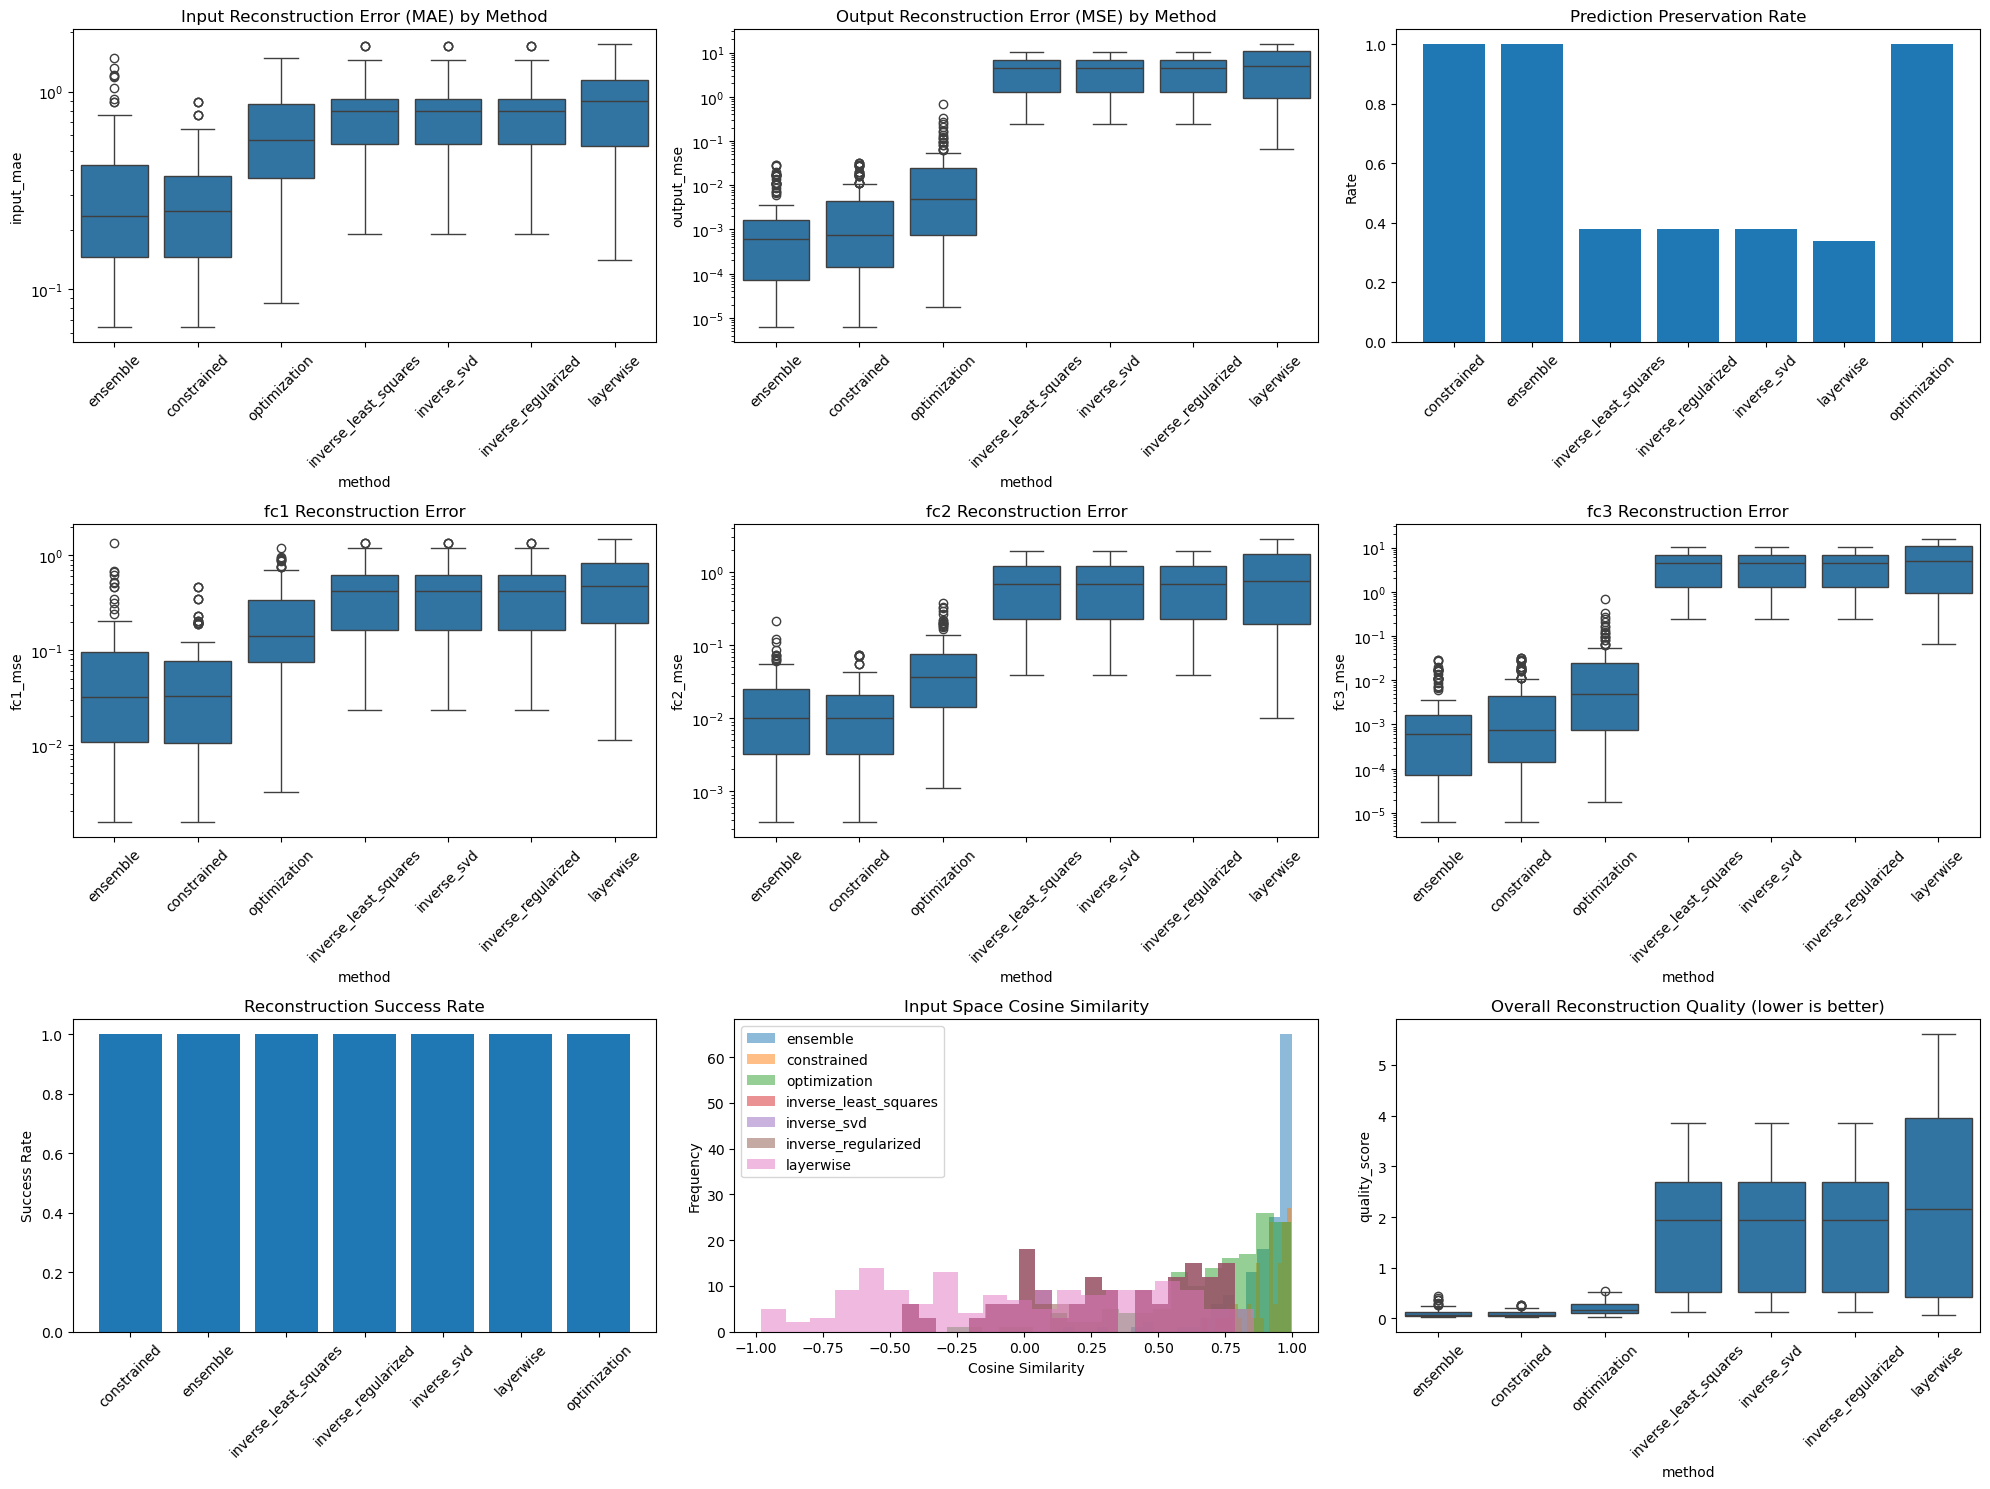


RECONSTRUCTION METHOD COMPARISON SUMMARY

ENSEMBLE:
  Success Rate: 1.000
  Input MAE: 0.329129 ± 0.269061
  Output MSE: 0.003049 ± 0.005926
  Prediction Preservation: 1.000
  Cosine Similarity: 0.889 ± 0.135

CONSTRAINED:
  Success Rate: 1.000
  Input MAE: 0.296275 ± 0.189439
  Output MSE: 0.004730 ± 0.008098
  Prediction Preservation: 1.000
  Cosine Similarity: 0.904 ± 0.083

OPTIMIZATION:
  Success Rate: 1.000
  Input MAE: 0.627497 ± 0.334429
  Output MSE: 0.029447 ± 0.073777
  Prediction Preservation: 1.000
  Cosine Similarity: 0.701 ± 0.257

INVERSE_LEAST_SQUARES:
  Success Rate: 1.000
  Input MAE: 0.768154 ± 0.322136
  Output MSE: 4.539347 ± 3.027002
  Prediction Preservation: 0.380
  Cosine Similarity: 0.309 ± 0.339

INVERSE_SVD:
  Success Rate: 1.000
  Input MAE: 0.768154 ± 0.322136
  Output MSE: 4.539347 ± 3.027002
  Prediction Preservation: 0.380
  Cosine Similarity: 0.309 ± 0.339

INVERSE_REGULARIZED:
  Success Rate: 1.000
  Input MAE: 0.768256 ± 0.322229
  Output MSE: 4.54

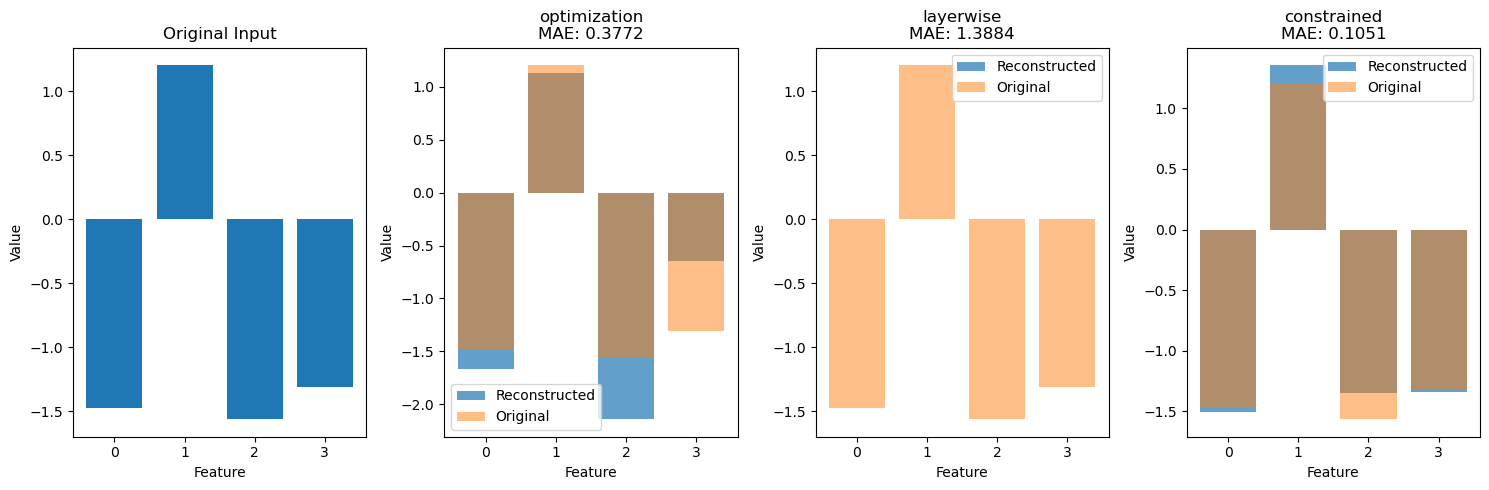


Experiment completed! Check the generated CSV file and plots for detailed results.


In [39]:
# %%
# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv('reconstruction_results_comprehensive.csv', index=False)
print("Results saved to reconstruction_results_comprehensive.csv")

# %%
# Analysis and Visualization
successful_results = results_df[results_df['reconstruction_success'] == True]

if len(successful_results) > 0:
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Input reconstruction error by method
    plt.subplot(3, 3, 1)
    method_order = successful_results.groupby('method')['input_mae'].median().sort_values().index
    sns.boxplot(x='method', y='input_mae', data=successful_results, order=method_order)
    plt.xticks(rotation=45)
    plt.title('Input Reconstruction Error (MAE) by Method')
    plt.yscale('log')
    
    # 2. Output reconstruction error
    plt.subplot(3, 3, 2)
    sns.boxplot(x='method', y='output_mse', data=successful_results, order=method_order)
    plt.xticks(rotation=45)
    plt.title('Output Reconstruction Error (MSE) by Method')
    plt.yscale('log')
    
    # 3. Prediction accuracy
    plt.subplot(3, 3, 3)
    pred_accuracy = successful_results.groupby('method')['same_prediction'].mean()
    plt.bar(pred_accuracy.index, pred_accuracy.values)
    plt.xticks(rotation=45)
    plt.title('Prediction Preservation Rate')
    plt.ylabel('Rate')
    
    # 4-6. Layer-wise reconstruction errors
    for idx, layer in enumerate(['fc1', 'fc2', 'fc3'], 4):
        plt.subplot(3, 3, idx)
        if f'{layer}_mse' in successful_results.columns:
            sns.boxplot(x='method', y=f'{layer}_mse', data=successful_results, order=method_order)
            plt.xticks(rotation=45)
            plt.title(f'{layer} Reconstruction Error')
            plt.yscale('log')
    
    # 7. Success rate by method
    plt.subplot(3, 3, 7)
    success_rate = results_df.groupby('method')['reconstruction_success'].mean()
    plt.bar(success_rate.index, success_rate.values)
    plt.xticks(rotation=45)
    plt.title('Reconstruction Success Rate')
    plt.ylabel('Success Rate')
    
    # 8. Cosine similarity distribution
    plt.subplot(3, 3, 8)
    for method in method_order:
        method_data = successful_results[successful_results['method'] == method]['input_cosine_sim']
        plt.hist(method_data, alpha=0.5, label=method, bins=20)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Input Space Cosine Similarity')
    
    # 9. Overall quality score
    plt.subplot(3, 3, 9)
    # Calculate composite score (lower is better)
    successful_results['quality_score'] = (
        successful_results['input_mae'] * 0.3 +
        successful_results['output_mse'] * 0.3 +
        (1 - successful_results['same_prediction']) * 0.4
    )
    sns.boxplot(x='method', y='quality_score', data=successful_results, order=method_order)
    plt.xticks(rotation=45)
    plt.title('Overall Reconstruction Quality (lower is better)')
    
    plt.tight_layout()
    plt.savefig('reconstruction_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("RECONSTRUCTION METHOD COMPARISON SUMMARY")
    print("="*80)
    
    for method in method_order:
        method_data = successful_results[successful_results['method'] == method]
        if len(method_data) > 0:
            print(f"\n{method.upper()}:")
            print(f"  Success Rate: {results_df[results_df['method'] == method]['reconstruction_success'].mean():.3f}")
            print(f"  Input MAE: {method_data['input_mae'].mean():.6f} ± {method_data['input_mae'].std():.6f}")
            print(f"  Output MSE: {method_data['output_mse'].mean():.6f} ± {method_data['output_mse'].std():.6f}")
            print(f"  Prediction Preservation: {method_data['same_prediction'].mean():.3f}")
            print(f"  Cosine Similarity: {method_data['input_cosine_sim'].mean():.3f} ± {method_data['input_cosine_sim'].std():.3f}")

    # Best method analysis
    print("\n" + "="*80)
    print("BEST METHOD BY METRIC:")
    print("="*80)
    
    metrics_to_minimize = ['input_mae', 'input_mse', 'output_mse', 'fc1_mse', 'fc2_mse', 'fc3_mse']
    metrics_to_maximize = ['input_cosine_sim', 'same_prediction']
    
    for metric in metrics_to_minimize:
        if metric in successful_results.columns:
            best_method = successful_results.groupby('method')[metric].mean().idxmin()
            best_value = successful_results.groupby('method')[metric].mean().min()
            print(f"  Best {metric}: {best_method} ({best_value:.6f})")
    
    for metric in metrics_to_maximize:
        if metric in successful_results.columns:
            best_method = successful_results.groupby('method')[metric].mean().idxmax()
            best_value = successful_results.groupby('method')[metric].mean().max()
            print(f"  Best {metric}: {best_method} ({best_value:.6f})")

# %%
# Visualize a specific reconstruction example
example_idx = 0
calibration_data = X_train[example_idx]

# Get target output
verified_model.eval()
with torch.no_grad():
    target_output = verified_model(calibration_data.unsqueeze(0))

# Get reconstructions from different methods
reconstructions = {}
for method in ['optimization', 'layerwise', 'constrained']:
    try:
        if method == 'optimization':
            recon = optimization_based_reconstruction(target_output, verified_model)
        elif method == 'layerwise':
            # Get target activations
            activations = {}
            hooks = []
            hooks.append(verified_model.fc1.register_forward_hook(get_activation('fc1', activations)))
            hooks.append(verified_model.fc2.register_forward_hook(get_activation('fc2', activations)))
            hooks.append(verified_model.fc3.register_forward_hook(get_activation('fc3', activations)))
            
            with torch.no_grad():
                _ = verified_model(calibration_data.unsqueeze(0))
                target_activations = {k: v.clone() for k, v in activations.items()}
            
            for hook in hooks:
                hook.remove()
            
            recon = layerwise_reconstruction(target_activations, verified_model)
        elif method == 'constrained':
            recon = constrained_reconstruction(target_output, verified_model, X_train)
        
        reconstructions[method] = recon
    except:
        pass

# Visualize
if reconstructions:
    plt.figure(figsize=(15, 5))
    
    # Original input
    plt.subplot(1, len(reconstructions) + 1, 1)
    plt.bar(range(4), calibration_data.numpy())
    plt.title('Original Input')
    plt.xlabel('Feature')
    plt.ylabel('Value')
    
    # Reconstructions
    for idx, (method, recon) in enumerate(reconstructions.items(), 2):
        plt.subplot(1, len(reconstructions) + 1, idx)
        plt.bar(range(4), recon.flatten().numpy(), alpha=0.7, label='Reconstructed')
        plt.bar(range(4), calibration_data.numpy(), alpha=0.5, label='Original')
        
        # Calculate error
        mae = F.l1_loss(calibration_data, recon.flatten()).item()
        plt.title(f'{method}\nMAE: {mae:.4f}')
        plt.xlabel('Feature')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('reconstruction_example_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nExperiment completed! Check the generated CSV file and plots for detailed results.")


# MULTIPLE TIME

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F

In [41]:
# Load and prepare data
data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


In [42]:
model = ANN(input_size=4, hidden_sizes=[64, 32], num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

epochs = 30
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [44]:
def get_activation(name, storage_dict):
    def hook(model, input, output):
        storage_dict[name] = output.detach()
    return hook

In [ ]:
def analyze_activation_reconstruction(model, X_data, n_samples=50, n_rounds=3, thresholds=None):

    if thresholds is None:
        thresholds = {
            'fc1': [0.001, 0.005, 0.007, 0.01, 0.05, 0.1],
            'fc2': [0.001, 0.005, 0.007, 0.01, 0.05, 0.1],
            'fc3': [0.001, 0.005, 0.007, 0.01, 0.05, 0.1]
        }
    
    layers = ['fc1', 'fc2', 'fc3']
    results = {layer: {thresh: [] for thresh in thresholds[layer]} for layer in layers}
    detailed_results = []
    
    for sample_idx in tqdm(range(min(n_samples, len(X_data))), desc="Processing samples"):
        original_input = X_data[sample_idx]
        
        # Get original activations
        original_activations = {}
        hooks = []
        for layer in layers:
            hooks.append(getattr(model, layer).register_forward_hook(
                get_activation(layer, original_activations)
            ))
        
        model.eval()
        with torch.no_grad():
            original_output = model(original_input.unsqueeze(0))
        
        for hook in hooks:
            hook.remove()
        
        # Reconstruction attempts for multiple rounds
        for round_idx in range(n_rounds):
            # Reconstruct input
            reconstructed_input = torch.randn(1, 4, requires_grad=True)
            optimizer = optim.Adam([reconstructed_input], lr=0.01)
            
            for _ in range(500):
                optimizer.zero_grad()
                output = model(reconstructed_input)
                loss = F.mse_loss(output, original_output)
                loss.backward()
                optimizer.step()
            
            # Get reconstructed activations
            reconstructed_activations = {}
            hooks = []
            for layer in layers:
                hooks.append(getattr(model, layer).register_forward_hook(
                    get_activation(layer, reconstructed_activations)
                ))
            
            with torch.no_grad():
                _ = model(reconstructed_input)
            
            for hook in hooks:
                hook.remove()
            
            # Calculate differences for each layer
            for layer in layers:
                orig_act = original_activations[layer].flatten()
                recon_act = reconstructed_activations[layer].flatten()
                
                # Element-wise absolute differences
                differences = torch.abs(orig_act - recon_act)
                
                # Check threshold passing for each activation
                for threshold in thresholds[layer]:
                    pass_rate = (differences < threshold).float().mean().item()
                    results[layer][threshold].append(pass_rate)
                
                # Store detailed results
                detailed_results.append({
                    'sample_idx': sample_idx,
                    'round_idx': round_idx,
                    'layer': layer,
                    'mean_diff': differences.mean().item(),
                    'max_diff': differences.max().item(),
                    'min_diff': differences.min().item(),
                    'std_diff': differences.std().item(),
                    'differences': differences.cpu().numpy()
                })
    
    return results, detailed_results

In [46]:
# Run analysis
print("Running activation reconstruction analysis...")
threshold_results, detailed_results = analyze_activation_reconstruction(
    model, X_train, n_samples=50, n_rounds=3
)

Running activation reconstruction analysis...


Processing samples: 100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


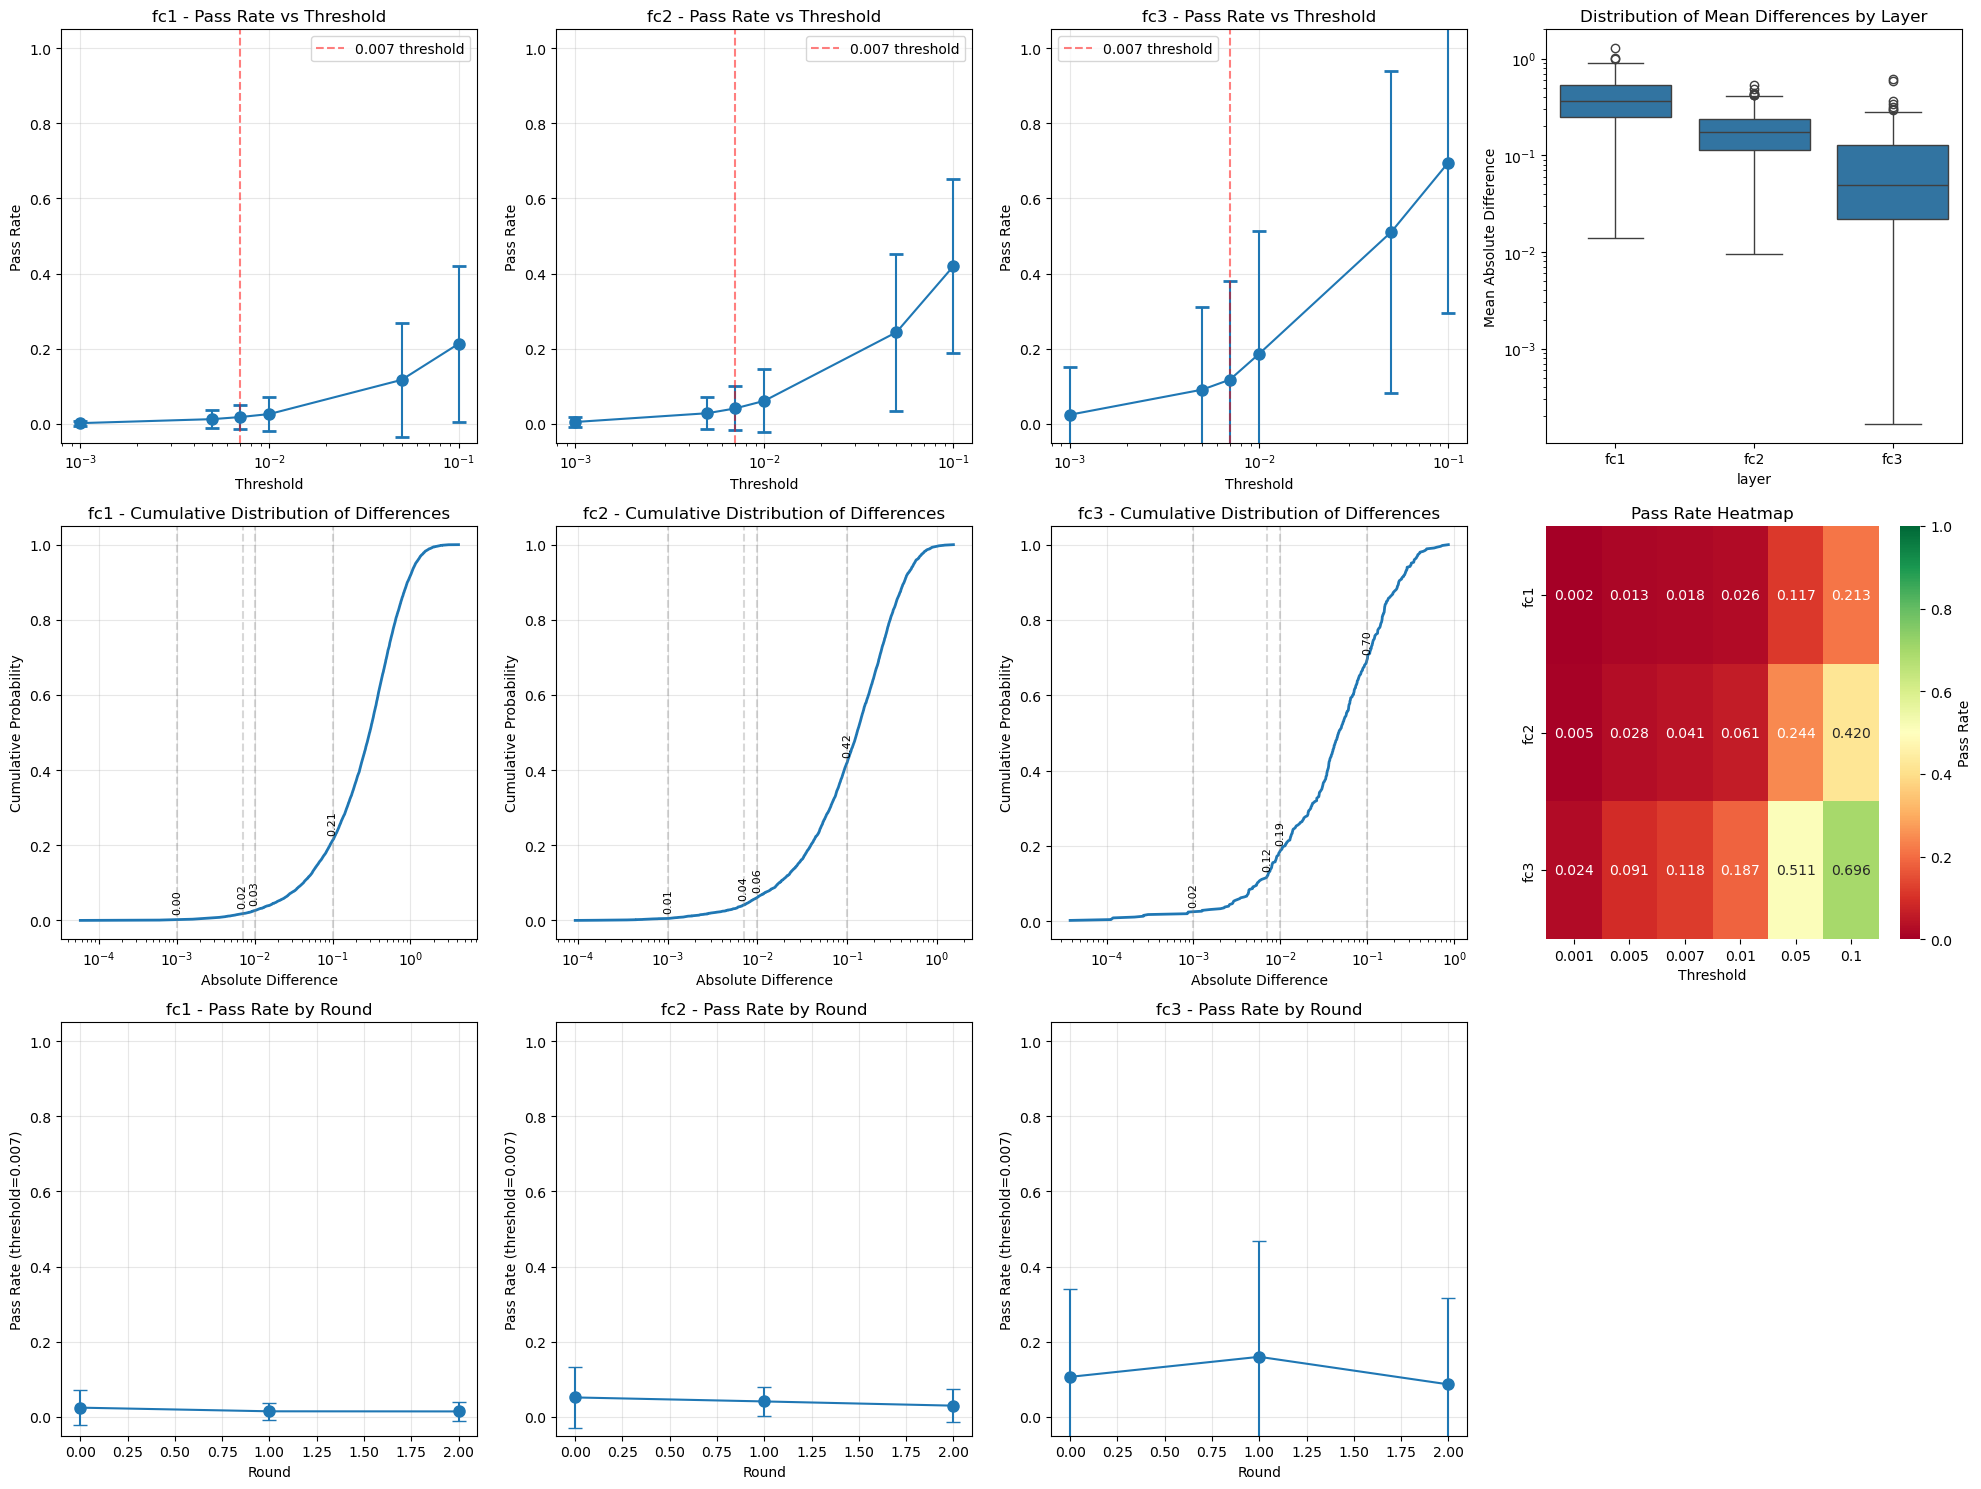


ACTIVATION RECONSTRUCTION ANALYSIS SUMMARY

PASS RATES AT THRESHOLD 0.007:
----------------------------------------
fc1:
  Mean pass rate: 0.018
  Std pass rate:  0.033
  Min pass rate:  0.000
  Max pass rate:  0.234
fc2:
  Mean pass rate: 0.041
  Std pass rate:  0.059
  Min pass rate:  0.000
  Max pass rate:  0.438
fc3:
  Mean pass rate: 0.118
  Std pass rate:  0.261
  Min pass rate:  0.000
  Max pass rate:  1.000

Analyzing individual neuron reconstruction...


Analyzing neurons: 100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


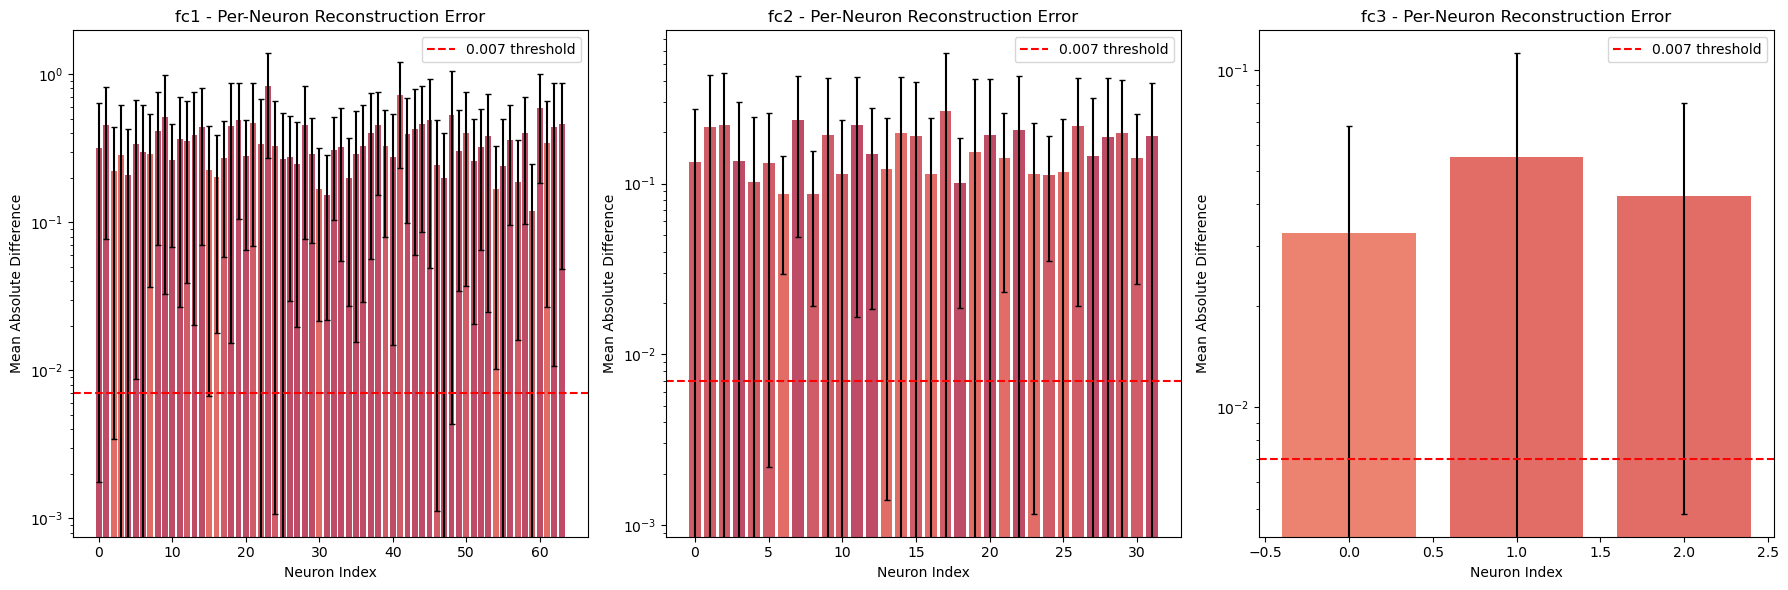


NEURON-LEVEL ANALYSIS (threshold = 0.007)

fc1:
  Total neurons: 64
  Neurons consistently passing (>80%): 0
  Percentage: 0.0%

fc2:
  Total neurons: 32
  Neurons consistently passing (>80%): 0
  Percentage: 0.0%

fc3:
  Total neurons: 3
  Neurons consistently passing (>80%): 0
  Percentage: 0.0%

Interpretation: Higher percentage indicates easier reconstruction for that layer


In [48]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Pass rate by threshold for each layer
for idx, layer in enumerate(['fc1', 'fc2', 'fc3'], 1):
    plt.subplot(3, 4, idx)
    
    thresholds = sorted(threshold_results[layer].keys())
    mean_pass_rates = [np.mean(threshold_results[layer][t]) for t in thresholds]
    std_pass_rates = [np.std(threshold_results[layer][t]) for t in thresholds]
    
    plt.errorbar(thresholds, mean_pass_rates, yerr=std_pass_rates, 
                 marker='o', capsize=5, capthick=2, markersize=8)
    plt.xlabel('Threshold')
    plt.ylabel('Pass Rate')
    plt.title(f'{layer} - Pass Rate vs Threshold')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.05, 1.05)
    
    # Add 0.007 threshold line
    plt.axvline(x=0.007, color='red', linestyle='--', alpha=0.5, label='0.007 threshold')
    plt.legend()

# 2. Cumulative distribution of differences for each layer
for idx, layer in enumerate(['fc1', 'fc2', 'fc3'], 5):
    plt.subplot(3, 4, idx)
    
    # Collect all differences for this layer
    all_diffs = []
    for result in detailed_results:
        if result['layer'] == layer:
            all_diffs.extend(result['differences'])
    
    # Plot cumulative distribution
    sorted_diffs = np.sort(all_diffs)
    cumulative = np.arange(1, len(sorted_diffs) + 1) / len(sorted_diffs)
    
    plt.plot(sorted_diffs, cumulative, linewidth=2)
    plt.xlabel('Absolute Difference')
    plt.ylabel('Cumulative Probability')
    plt.title(f'{layer} - Cumulative Distribution of Differences')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    
    # Add threshold lines
    for threshold in [0.001, 0.007, 0.01, 0.1]:
        plt.axvline(x=threshold, color='gray', linestyle='--', alpha=0.3)
        # Find cumulative probability at this threshold
        cum_prob = np.mean(np.array(all_diffs) < threshold)
        plt.text(threshold, cum_prob + 0.02, f'{cum_prob:.2f}', 
                rotation=90, fontsize=8, ha='center')

# 3. Box plots of differences by layer
plt.subplot(3, 4, 4)
df_detailed = pd.DataFrame(detailed_results)
df_melted = df_detailed[['layer', 'mean_diff']]
sns.boxplot(x='layer', y='mean_diff', data=df_melted)
plt.ylabel('Mean Absolute Difference')
plt.title('Distribution of Mean Differences by Layer')
plt.yscale('log')

# 4. Heatmap of pass rates
plt.subplot(3, 4, 8)
layers = ['fc1', 'fc2', 'fc3']
thresholds = [0.001, 0.005, 0.007, 0.01, 0.05, 0.1]
pass_rate_matrix = np.zeros((len(layers), len(thresholds)))

for i, layer in enumerate(layers):
    for j, threshold in enumerate(thresholds):
        pass_rate_matrix[i, j] = np.mean(threshold_results[layer][threshold])

sns.heatmap(pass_rate_matrix, 
            xticklabels=[f'{t}' for t in thresholds],
            yticklabels=layers,
            annot=True, 
            fmt='.3f',
            cmap='RdYlGn',
            vmin=0, vmax=1,
            cbar_kws={'label': 'Pass Rate'})
plt.xlabel('Threshold')
plt.title('Pass Rate Heatmap')

# 5. Pass rate progression across rounds
for idx, layer in enumerate(['fc1', 'fc2', 'fc3'], 9):
    plt.subplot(3, 4, idx)
    
    # Analyze by round
    round_pass_rates = {r: [] for r in range(3)}
    threshold = 0.007
    
    for result in detailed_results:
        if result['layer'] == layer:
            diffs = result['differences']
            pass_rate = np.mean(diffs < threshold)
            round_pass_rates[result['round_idx']].append(pass_rate)
    
    # Plot
    rounds = list(round_pass_rates.keys())
    means = [np.mean(round_pass_rates[r]) for r in rounds]
    stds = [np.std(round_pass_rates[r]) for r in rounds]
    
    plt.errorbar(rounds, means, yerr=stds, marker='o', capsize=5, markersize=8)
    plt.xlabel('Round')
    plt.ylabel('Pass Rate (threshold=0.007)')
    plt.title(f'{layer} - Pass Rate by Round')
    plt.ylim(-0.05, 1.05)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('activation_reconstruction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Create summary statistics table
print("\n" + "="*80)
print("ACTIVATION RECONSTRUCTION ANALYSIS SUMMARY")
print("="*80)

# Summary for threshold 0.007
print("\nPASS RATES AT THRESHOLD 0.007:")
print("-" * 40)
for layer in ['fc1', 'fc2', 'fc3']:
    pass_rates = threshold_results[layer][0.007]
    print(f"{layer}:")
    print(f"  Mean pass rate: {np.mean(pass_rates):.3f}")
    print(f"  Std pass rate:  {np.std(pass_rates):.3f}")
    print(f"  Min pass rate:  {np.min(pass_rates):.3f}")
    print(f"  Max pass rate:  {np.max(pass_rates):.3f}")

# %%
# Create detailed per-neuron analysis
def analyze_neuron_reconstruction(model, X_data, n_samples=20):
    """Analyze reconstruction quality for individual neurons"""
    
    layers = ['fc1', 'fc2', 'fc3']
    neuron_results = {layer: {} for layer in layers}
    
    for sample_idx in tqdm(range(min(n_samples, len(X_data))), desc="Analyzing neurons"):
        original_input = X_data[sample_idx]
        
        # Get original activations
        original_activations = {}
        hooks = []
        for layer in layers:
            hooks.append(getattr(model, layer).register_forward_hook(
                get_activation(layer, original_activations)
            ))
        
        model.eval()
        with torch.no_grad():
            original_output = model(original_input.unsqueeze(0))
        
        for hook in hooks:
            hook.remove()
        
        # Reconstruct
        reconstructed_input = torch.randn(1, 4, requires_grad=True)
        optimizer = optim.Adam([reconstructed_input], lr=0.01)
        
        for _ in range(500):
            optimizer.zero_grad()
            output = model(reconstructed_input)
            loss = F.mse_loss(output, original_output)
            loss.backward()
            optimizer.step()
        
        # Get reconstructed activations
        reconstructed_activations = {}
        hooks = []
        for layer in layers:
            hooks.append(getattr(model, layer).register_forward_hook(
                get_activation(layer, reconstructed_activations)
            ))
        
        with torch.no_grad():
            _ = model(reconstructed_input)
        
        for hook in hooks:
            hook.remove()
        
        # Analyze per neuron
        for layer in layers:
            orig_act = original_activations[layer].squeeze()
            recon_act = reconstructed_activations[layer].squeeze()
            
            for neuron_idx in range(orig_act.shape[0]):
                if neuron_idx not in neuron_results[layer]:
                    neuron_results[layer][neuron_idx] = []
                
                diff = abs(orig_act[neuron_idx].item() - recon_act[neuron_idx].item())
                neuron_results[layer][neuron_idx].append(diff)
    
    return neuron_results

# %%
print("\nAnalyzing individual neuron reconstruction...")
neuron_results = analyze_neuron_reconstruction(model, X_train, n_samples=20)

# %%
# Visualize neuron-level results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, layer in enumerate(['fc1', 'fc2', 'fc3']):
    ax = axes[idx]
    
    # Calculate mean difference for each neuron
    neuron_means = []
    neuron_stds = []
    
    for neuron_idx in sorted(neuron_results[layer].keys()):
        diffs = neuron_results[layer][neuron_idx]
        neuron_means.append(np.mean(diffs))
        neuron_stds.append(np.std(diffs))
    
    # Plot
    neuron_indices = range(len(neuron_means))
    ax.bar(neuron_indices, neuron_means, yerr=neuron_stds, capsize=2, alpha=0.7)
    ax.axhline(y=0.007, color='red', linestyle='--', label='0.007 threshold')
    ax.set_xlabel('Neuron Index')
    ax.set_ylabel('Mean Absolute Difference')
    ax.set_title(f'{layer} - Per-Neuron Reconstruction Error')
    ax.set_yscale('log')
    ax.legend()
    
    # Highlight neurons that consistently pass/fail threshold
    pass_rate_per_neuron = []
    for neuron_idx in sorted(neuron_results[layer].keys()):
        diffs = neuron_results[layer][neuron_idx]
        pass_rate = np.mean([d < 0.007 for d in diffs])
        pass_rate_per_neuron.append(pass_rate)
    
    # Color bars based on pass rate
    colors = plt.cm.RdYlGn([pr for pr in pass_rate_per_neuron])
    for bar, color in zip(ax.patches, colors):
        bar.set_facecolor(color)

plt.tight_layout()
plt.savefig('neuron_level_reconstruction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Print neuron statistics
print("\n" + "="*80)
print("NEURON-LEVEL ANALYSIS (threshold = 0.007)")
print("="*80)

for layer in ['fc1', 'fc2', 'fc3']:
    neurons_passing = 0
    total_neurons = len(neuron_results[layer])
    
    for neuron_idx in neuron_results[layer]:
        diffs = neuron_results[layer][neuron_idx]
        pass_rate = np.mean([d < 0.007 for d in diffs])
        if pass_rate > 0.8:  # Consider neuron as "passing" if >80% samples pass
            neurons_passing += 1
    
    print(f"\n{layer}:")
    print(f"  Total neurons: {total_neurons}")
    print(f"  Neurons consistently passing (>80%): {neurons_passing}")
    print(f"  Percentage: {100 * neurons_passing / total_neurons:.1f}%")

print("\nInterpretation: Higher percentage indicates easier reconstruction for that layer")

Generating activation differences...


Processing samples: 100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


Results saved. Shape: (500, 11)


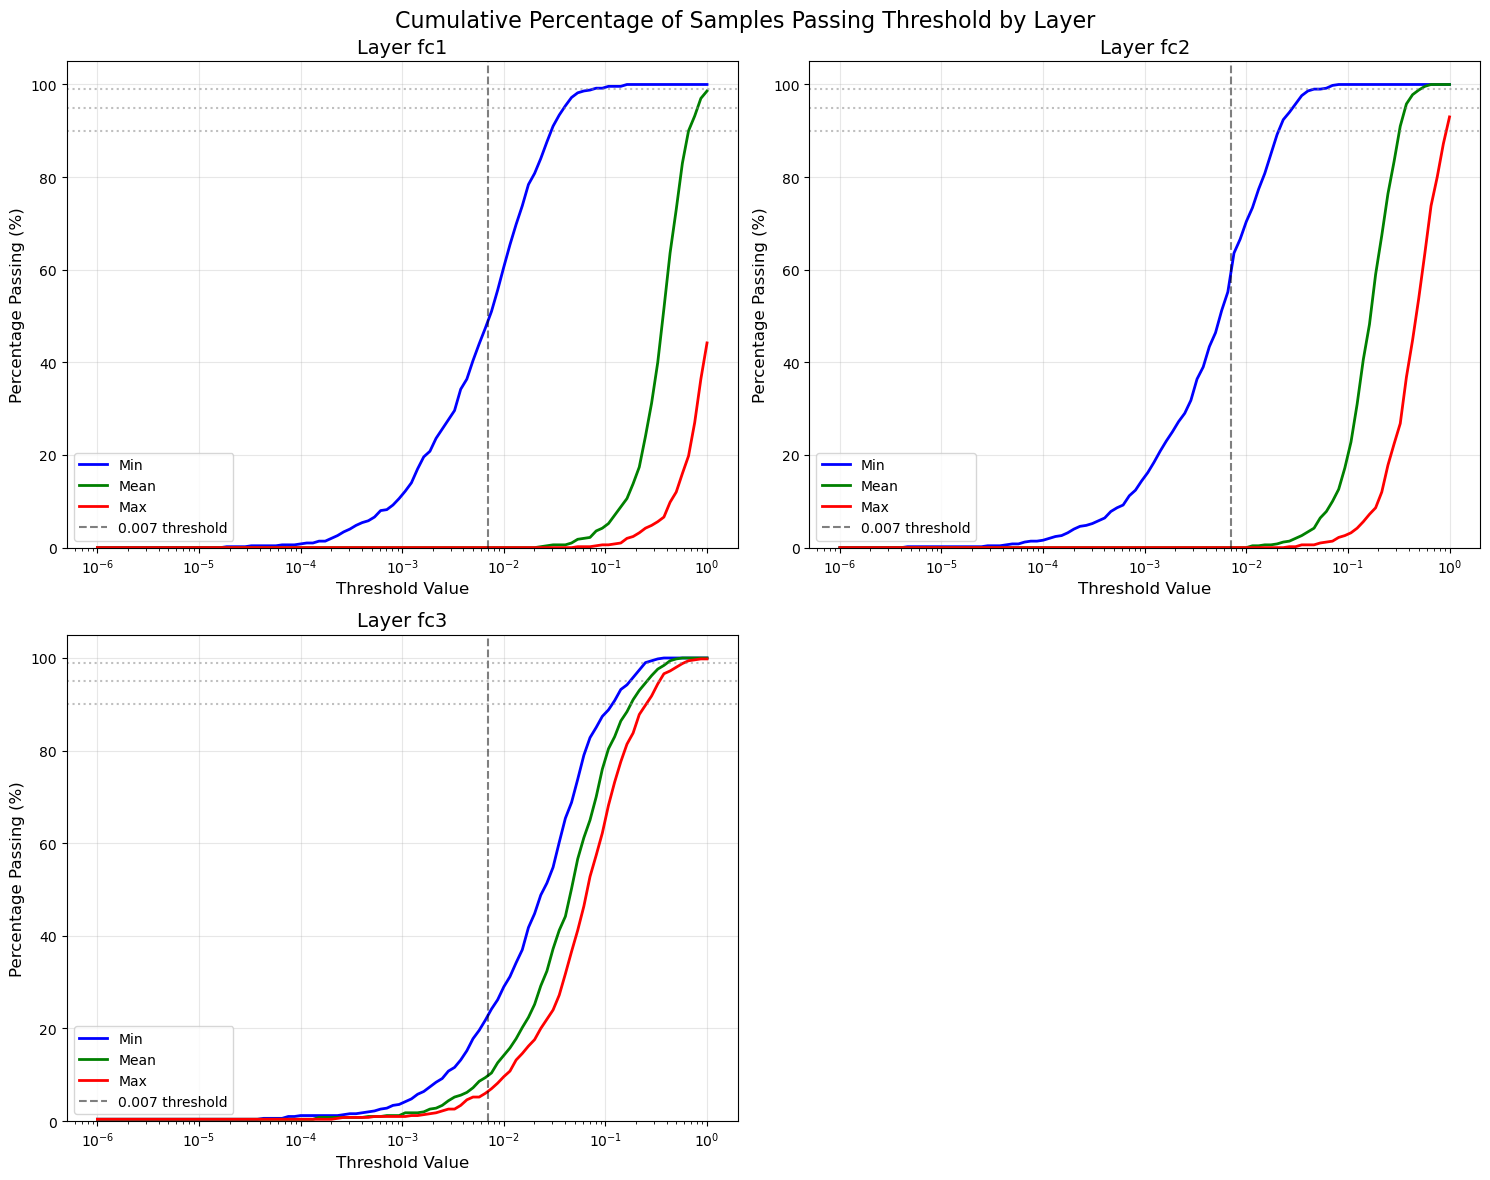


Threshold Analysis Table:
Layer  Threshold Min Pass % Mean Pass % Max Pass %
  fc1      0.001      12.0%        0.0%       0.0%
  fc1      0.005      40.4%        0.0%       0.0%
  fc1      0.007      48.2%        0.0%       0.0%
  fc1      0.010      60.6%        0.0%       0.0%
  fc1      0.050      97.8%        1.2%       0.0%
  fc1      0.100      99.6%        4.4%       0.6%
  fc2      0.001      14.8%        0.0%       0.0%
  fc2      0.005      46.4%        0.0%       0.0%
  fc2      0.007      58.0%        0.0%       0.0%
  fc2      0.010      70.4%        0.0%       0.0%
  fc2      0.050      99.0%        4.4%       0.6%
  fc2      0.100     100.0%       19.8%       2.8%
  fc3      0.001       3.6%        1.4%       1.0%
  fc3      0.005      17.8%        7.2%       5.2%
  fc3      0.007      23.0%       10.2%       6.4%
  fc3      0.010      29.0%       14.2%       9.6%
  fc3      0.050      71.6%       53.6%      39.6%
  fc3      0.100      88.2%       78.0%      66.0%


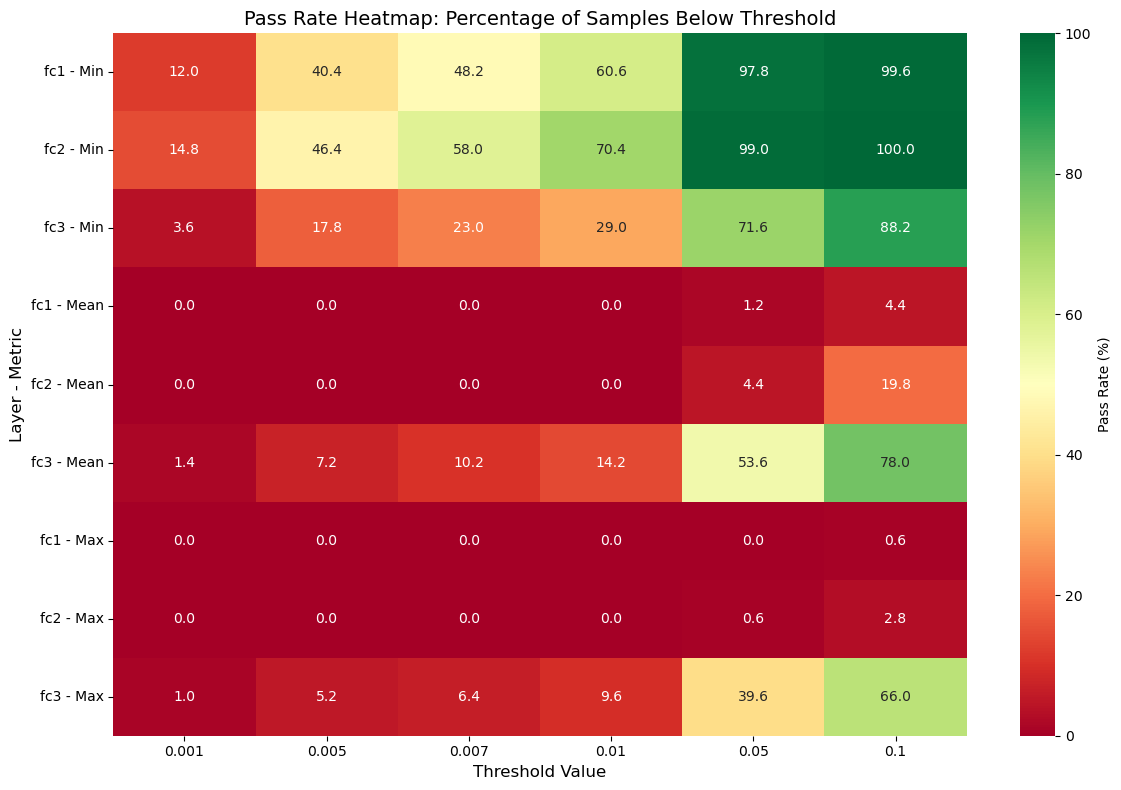

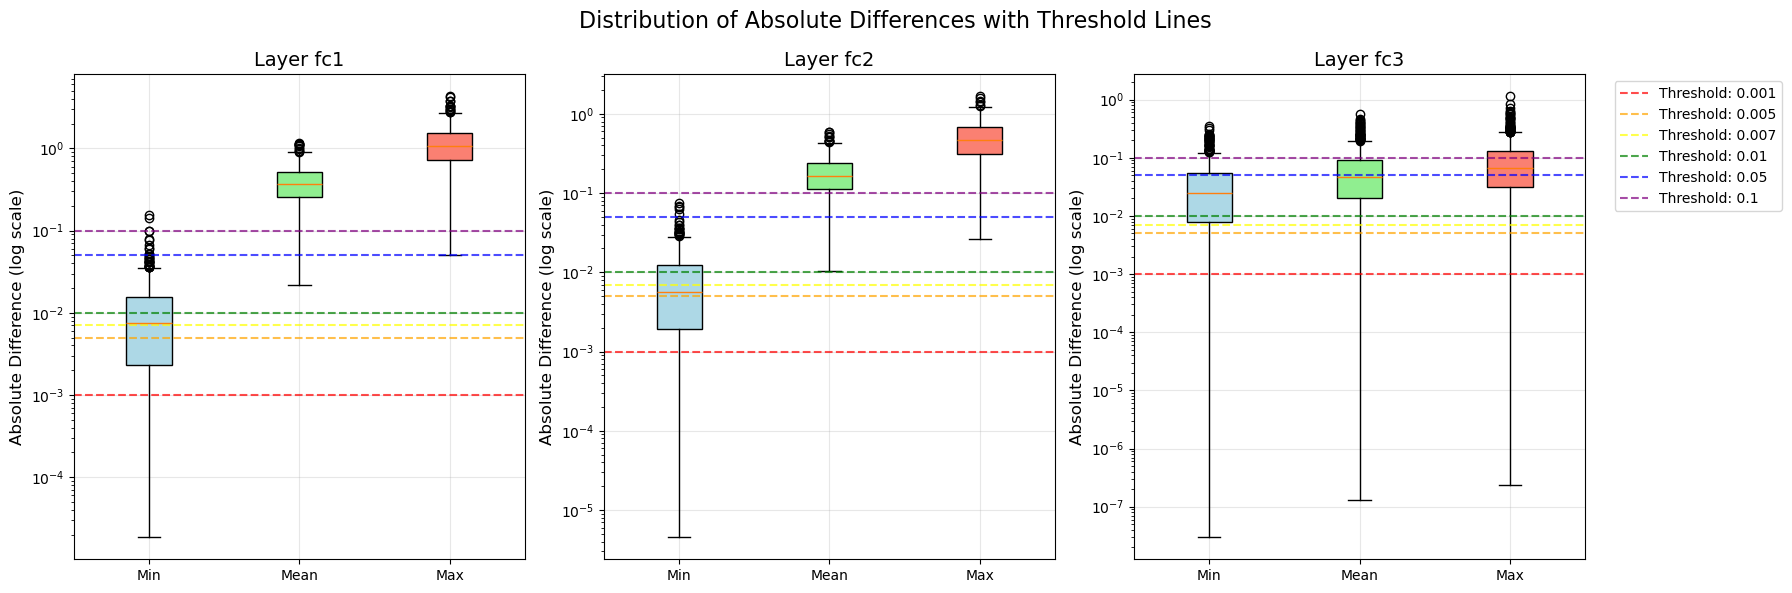


Summary Statistics for Threshold Selection:

Layer fc1:
----------------------------------------

Min Metric:
  Threshold for 90% pass rate: 0.029189
  Threshold for 95% pass rate: 0.037624
  Threshold for 99% pass rate: 0.075792
  Threshold for 99.9% pass rate: 0.149610

Mean Metric:
  Threshold for 90% pass rate: 0.656634
  Threshold for 95% pass rate: 0.800579
  Threshold for 99% pass rate: 1.104878
  Threshold for 99.9% pass rate: 1.156140

Max Metric:
  Threshold for 90% pass rate: 2.010692
  Threshold for 95% pass rate: 2.442673
  Threshold for 99% pass rate: 3.255973
  Threshold for 99.9% pass rate: 4.245982

Layer fc2:
----------------------------------------

Min Metric:
  Threshold for 90% pass rate: 0.020884
  Threshold for 95% pass rate: 0.027788
  Threshold for 99% pass rate: 0.046147
  Threshold for 99.9% pass rate: 0.071873

Mean Metric:
  Threshold for 90% pass rate: 0.322063
  Threshold for 95% pass rate: 0.367752
  Threshold for 99% pass rate: 0.507377
  Threshold fo

Analyzing neurons: 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]


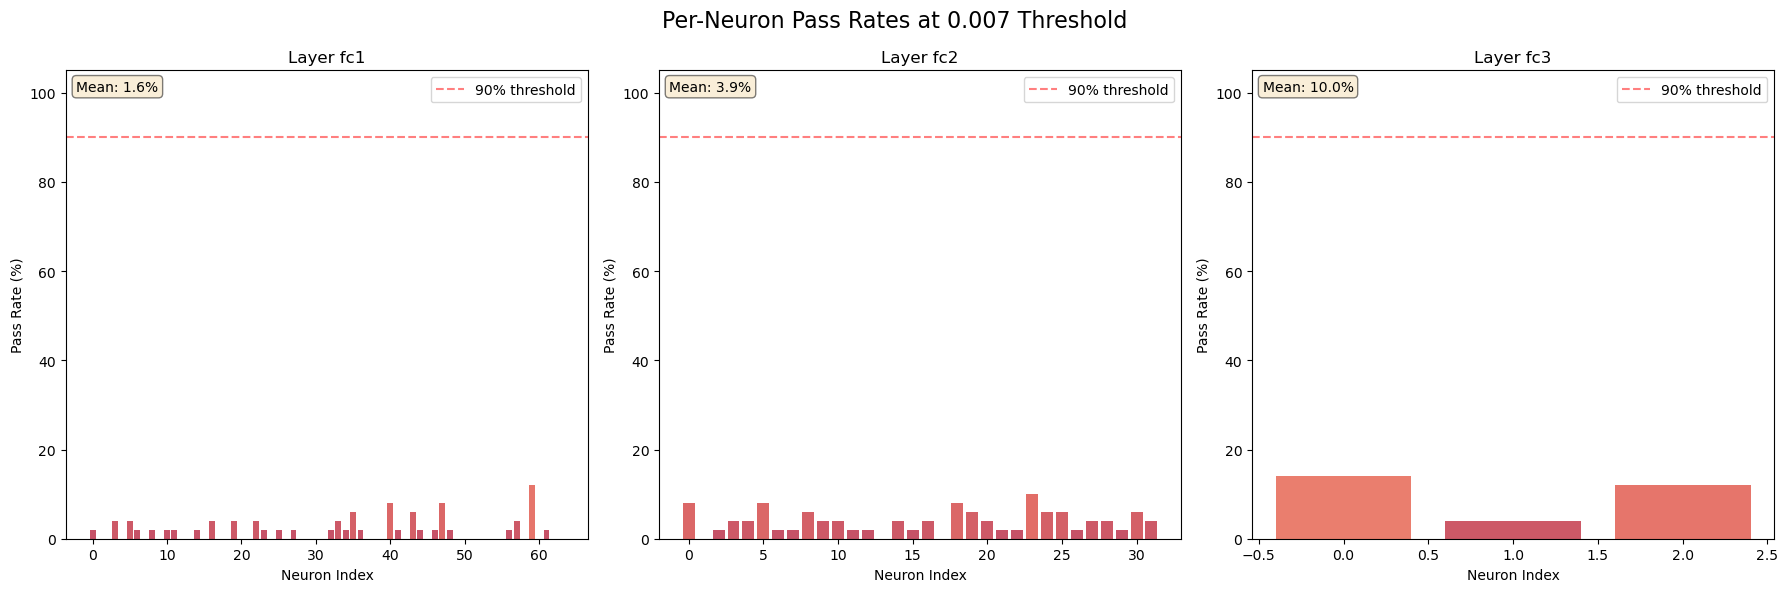


ACTIVATION RECONSTRUCTION ANALYSIS REPORT

OVERALL PASS RATES AT 0.007 THRESHOLD:
----------------------------------------

fc1:
  Min: 48.2%
  Mean: 0.0%
  Max: 0.0%

fc2:
  Min: 58.0%
  Mean: 0.0%
  Max: 0.0%

fc3:
  Min: 23.0%
  Mean: 10.2%
  Max: 6.4%


NEURON-LEVEL SUMMARY (0.007 threshold):
----------------------------------------

fc1:
  Total neurons: 64
  Neurons with >90% pass rate: 0 (0.0%)
  Mean neuron pass rate: 1.6%
  Min neuron pass rate: 0.0%
  Max neuron pass rate: 12.0%

fc2:
  Total neurons: 32
  Neurons with >90% pass rate: 0 (0.0%)
  Mean neuron pass rate: 3.9%
  Min neuron pass rate: 0.0%
  Max neuron pass rate: 10.0%

fc3:
  Total neurons: 3
  Neurons with >90% pass rate: 0 (0.0%)
  Mean neuron pass rate: 10.0%
  Min neuron pass rate: 4.0%
  Max neuron pass rate: 14.0%


In [49]:
# %%
# Generate activation difference data
def generate_activation_differences(model, X_data, n_samples=100, n_reconstructions=5):
    """Generate activation differences between original and reconstructed inputs"""
    
    results = []
    layers = ['fc1', 'fc2', 'fc3']
    
    for sample_idx in tqdm(range(min(n_samples, len(X_data))), desc="Processing samples"):
        original_input = X_data[sample_idx]
        
        # Get original activations
        original_activations = {}
        hooks = []
        for layer in layers:
            hooks.append(getattr(model, layer).register_forward_hook(
                get_activation(layer, original_activations)
            ))
        
        model.eval()
        with torch.no_grad():
            original_output = model(original_input.unsqueeze(0))
        
        for hook in hooks:
            hook.remove()
        
        # Multiple reconstruction attempts
        for recon_idx in range(n_reconstructions):
            # Reconstruct input
            reconstructed_input = torch.randn(1, 4, requires_grad=True)
            optimizer = optim.Adam([reconstructed_input], lr=0.01)
            
            for _ in range(500):
                optimizer.zero_grad()
                output = model(reconstructed_input)
                loss = nn.functional.mse_loss(output, original_output)
                loss.backward()
                optimizer.step()
            
            # Get reconstructed activations
            reconstructed_activations = {}
            hooks = []
            for layer in layers:
                hooks.append(getattr(model, layer).register_forward_hook(
                    get_activation(layer, reconstructed_activations)
                ))
            
            with torch.no_grad():
                _ = model(reconstructed_input)
            
            for hook in hooks:
                hook.remove()
            
            # Calculate differences
            row = {'sample_idx': sample_idx, 'reconstruction_idx': recon_idx}
            
            for layer in layers:
                orig_act = original_activations[layer].flatten()
                recon_act = reconstructed_activations[layer].flatten()
                
                abs_diff = torch.abs(orig_act - recon_act)
                
                row[f'{layer}_min_abs_diff'] = abs_diff.min().item()
                row[f'{layer}_mean_abs_diff'] = abs_diff.mean().item()
                row[f'{layer}_max_abs_diff'] = abs_diff.max().item()
            
            results.append(row)
    
    return pd.DataFrame(results)

# %%
# Generate results
print("Generating activation differences...")
results = generate_activation_differences(model, X_train, n_samples=100, n_reconstructions=5)

# Save results
results.to_csv('activation_diff_results.csv', index=False)
print(f"Results saved. Shape: {results.shape}")

# %%
# Define threshold values to test
thresholds = np.logspace(-6, 0, 100)  # From 1e-6 to 1 (0.000001 to 1)

# Create figure for cumulative distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Cumulative Percentage of Samples Passing Threshold by Layer', fontsize=16)

layers = ['fc1', 'fc2', 'fc3']
metrics = ['min_abs_diff', 'mean_abs_diff', 'max_abs_diff']
colors = {'min_abs_diff': 'blue', 'mean_abs_diff': 'green', 'max_abs_diff': 'red'}

# Plot for each layer
for idx, layer in enumerate(layers):
    ax = axes[idx//2, idx%2]
    
    for metric in metrics:
        column = f'{layer}_{metric}'
        values = results[column].values
        
        # Calculate percentage passing each threshold
        percentages = []
        for threshold in thresholds:
            passing = np.sum(values <= threshold) / len(values) * 100
            percentages.append(passing)
        
        # Plot cumulative distribution
        ax.semilogx(thresholds, percentages, 
                   label=metric.replace('_abs_diff', '').capitalize(),
                   color=colors[metric], linewidth=2)
    
    # Add reference lines for common thresholds
    ax.axvline(x=0.007, color='black', linestyle='--', alpha=0.5, label='0.007 threshold')
    ax.axhline(y=90, color='gray', linestyle=':', alpha=0.5)
    ax.axhline(y=95, color='gray', linestyle=':', alpha=0.5)
    ax.axhline(y=99, color='gray', linestyle=':', alpha=0.5)
    
    ax.set_xlabel('Threshold Value', fontsize=12)
    ax.set_ylabel('Percentage Passing (%)', fontsize=12)
    ax.set_title(f'Layer {layer}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 105)

# Remove empty subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('cumulative_threshold_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Create a detailed threshold analysis table
threshold_values = [0.001, 0.005, 0.007, 0.01, 0.05, 0.1]
analysis_results = []

for layer in layers:
    for threshold in threshold_values:
        row = {'Layer': layer, 'Threshold': threshold}
        
        for metric in metrics:
            column = f'{layer}_{metric}'
            values = results[column].values
            passing_percentage = np.sum(values <= threshold) / len(values) * 100
            row[f'{metric.replace("_abs_diff", "").capitalize()} Pass %'] = f'{passing_percentage:.1f}%'
        
        analysis_results.append(row)

# Create DataFrame and display
threshold_df = pd.DataFrame(analysis_results)
print("\nThreshold Analysis Table:")
print("="*80)
print(threshold_df.to_string(index=False))

# Save to CSV
threshold_df.to_csv('threshold_analysis.csv', index=False)

# %%
# Create a heatmap showing pass rates for different thresholds and layers
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = []
heatmap_labels = []

for metric in metrics:
    metric_data = []
    for layer in layers:
        column = f'{layer}_{metric}'
        values = results[column].values
        
        # Calculate pass rates for each threshold
        pass_rates = []
        for threshold in threshold_values:
            passing = np.sum(values <= threshold) / len(values) * 100
            pass_rates.append(passing)
        
        metric_data.append(pass_rates)
    
    heatmap_data.extend(metric_data)
    heatmap_labels.extend([f'{layer} - {metric.replace("_abs_diff", "").capitalize()}' 
                          for layer in layers])

# Create heatmap
heatmap_array = np.array(heatmap_data)
sns.heatmap(heatmap_array, 
            xticklabels=[f'{t}' for t in threshold_values],
            yticklabels=heatmap_labels,
            annot=True, 
            fmt='.1f',
            cmap='RdYlGn',
            cbar_kws={'label': 'Pass Rate (%)'},
            vmin=0, vmax=100)

plt.title('Pass Rate Heatmap: Percentage of Samples Below Threshold', fontsize=14)
plt.xlabel('Threshold Value', fontsize=12)
plt.ylabel('Layer - Metric', fontsize=12)
plt.tight_layout()
plt.savefig('threshold_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Create box plots showing the distribution of differences for each layer
# with threshold lines overlaid
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribution of Absolute Differences with Threshold Lines', fontsize=16)

for idx, layer in enumerate(layers):
    ax = axes[idx]
    
    # Prepare data for box plot
    data_to_plot = []
    labels_to_plot = []
    
    for metric in metrics:
        column = f'{layer}_{metric}'
        data_to_plot.append(results[column].values)
        labels_to_plot.append(metric.replace('_abs_diff', '').capitalize())
    
    # Create box plot
    bp = ax.boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True)
    
    # Color the boxes
    colors_list = ['lightblue', 'lightgreen', 'salmon']
    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
    
    # Add threshold lines
    threshold_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
    for thresh, color in zip(threshold_values, threshold_colors):
        ax.axhline(y=thresh, color=color, linestyle='--', alpha=0.7, 
                  label=f'Threshold: {thresh}')
    
    ax.set_yscale('log')
    ax.set_ylabel('Absolute Difference (log scale)', fontsize=12)
    ax.set_title(f'Layer {layer}', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Only show legend on the last subplot
    if idx == 2:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('distribution_with_thresholds.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Summary statistics for threshold selection
print("\nSummary Statistics for Threshold Selection:")
print("="*80)

for layer in layers:
    print(f"\nLayer {layer}:")
    print("-"*40)
    
    for metric in metrics:
        column = f'{layer}_{metric}'
        values = results[column].values
        
        # Find threshold for different pass rates
        pass_rates = [90, 95, 99, 99.9]
        print(f"\n{metric.replace('_abs_diff', '').capitalize()} Metric:")
        
        for rate in pass_rates:
            threshold_for_rate = np.percentile(values, rate)
            print(f"  Threshold for {rate}% pass rate: {threshold_for_rate:.6f}")

# %%
# Additional analysis: Per-neuron pass rates at 0.007 threshold
def analyze_neuron_pass_rates(model, X_data, threshold=0.007, n_samples=50):
    """Analyze pass rates for individual neurons at specified threshold"""
    
    layers = ['fc1', 'fc2', 'fc3']
    neuron_pass_counts = {layer: {} for layer in layers}
    
    for sample_idx in tqdm(range(min(n_samples, len(X_data))), desc="Analyzing neurons"):
        original_input = X_data[sample_idx]
        
        # Get original activations
        original_activations = {}
        hooks = []
        for layer in layers:
            hooks.append(getattr(model, layer).register_forward_hook(
                get_activation(layer, original_activations)
            ))
        
        model.eval()
        with torch.no_grad():
            original_output = model(original_input.unsqueeze(0))
        
        for hook in hooks:
            hook.remove()
        
        # Reconstruct
        reconstructed_input = torch.randn(1, 4, requires_grad=True)
        optimizer = optim.Adam([reconstructed_input], lr=0.01)
        
        for _ in range(500):
            optimizer.zero_grad()
            output = model(reconstructed_input)
            loss = nn.functional.mse_loss(output, original_output)
            loss.backward()
            optimizer.step()
        
        # Get reconstructed activations
        reconstructed_activations = {}
        hooks = []
        for layer in layers:
            hooks.append(getattr(model, layer).register_forward_hook(
                get_activation(layer, reconstructed_activations)
            ))
        
        with torch.no_grad():
            _ = model(reconstructed_input)
        
        for hook in hooks:
            hook.remove()
        
        # Check each neuron
        for layer in layers:
            orig_act = original_activations[layer].squeeze()
            recon_act = reconstructed_activations[layer].squeeze()
            
            for neuron_idx in range(orig_act.shape[0]):
                if neuron_idx not in neuron_pass_counts[layer]:
                    neuron_pass_counts[layer][neuron_idx] = 0
                
                diff = abs(orig_act[neuron_idx].item() - recon_act[neuron_idx].item())
                if diff < threshold:
                    neuron_pass_counts[layer][neuron_idx] += 1
    
    # Convert to pass rates
    neuron_pass_rates = {}
    for layer in layers:
        neuron_pass_rates[layer] = {
            neuron: count / n_samples * 100 
            for neuron, count in neuron_pass_counts[layer].items()
        }
    
    return neuron_pass_rates

# %%
print("\nAnalyzing per-neuron pass rates at 0.007 threshold...")
neuron_pass_rates = analyze_neuron_pass_rates(model, X_train, threshold=0.007, n_samples=50)

# %%
# Visualize neuron pass rates
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Per-Neuron Pass Rates at 0.007 Threshold', fontsize=16)

for idx, layer in enumerate(layers):
    ax = axes[idx]
    
    neuron_indices = sorted(neuron_pass_rates[layer].keys())
    pass_rates = [neuron_pass_rates[layer][n] for n in neuron_indices]
    
    bars = ax.bar(neuron_indices, pass_rates, alpha=0.7)
    
    # Color bars based on pass rate
    colors = plt.cm.RdYlGn([pr/100 for pr in pass_rates])
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)
    
    ax.axhline(y=90, color='red', linestyle='--', alpha=0.5, label='90% threshold')
    ax.set_xlabel('Neuron Index')
    ax.set_ylabel('Pass Rate (%)')
    ax.set_title(f'Layer {layer}')
    ax.set_ylim(0, 105)
    ax.legend()
    
    # Add statistics
    mean_pass_rate = np.mean(pass_rates)
    ax.text(0.02, 0.98, f'Mean: {mean_pass_rate:.1f}%', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('neuron_pass_rates.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Final summary report
print("\n" + "="*80)
print("ACTIVATION RECONSTRUCTION ANALYSIS REPORT")
print("="*80)

# Overall statistics at 0.007 threshold
print("\nOVERALL PASS RATES AT 0.007 THRESHOLD:")
print("-"*40)

for layer in layers:
    print(f"\n{layer}:")
    for metric in metrics:
        column = f'{layer}_{metric}'
        values = results[column].values
        pass_rate = np.sum(values <= 0.007) / len(values) * 100
        print(f"  {metric.replace('_abs_diff', '').capitalize()}: {pass_rate:.1f}%")

# Neuron-level summary
print("\n\nNEURON-LEVEL SUMMARY (0.007 threshold):")
print("-"*40)

for layer in layers:
    pass_rates = list(neuron_pass_rates[layer].values())
    neurons_above_90 = sum(1 for pr in pass_rates if pr >= 90)
    total_neurons = len(pass_rates)
    
    print(f"\n{layer}:")
    print(f"  Total neurons: {total_neurons}")
    print(f"  Neurons with >90% pass rate: {neurons_above_90} ({neurons_above_90/total_neurons*100:.1f}%)")
    print(f"  Mean neuron pass rate: {np.mean(pass_rates):.1f}%")
    print(f"  Min neuron pass rate: {np.min(pass_rates):.1f}%")
    print(f"  Max neuron pass rate: {np.max(pass_rates):.1f}%")

Generating activation differences with all-layer checks...


Processing samples: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Results saved. Shape: (500, 13)


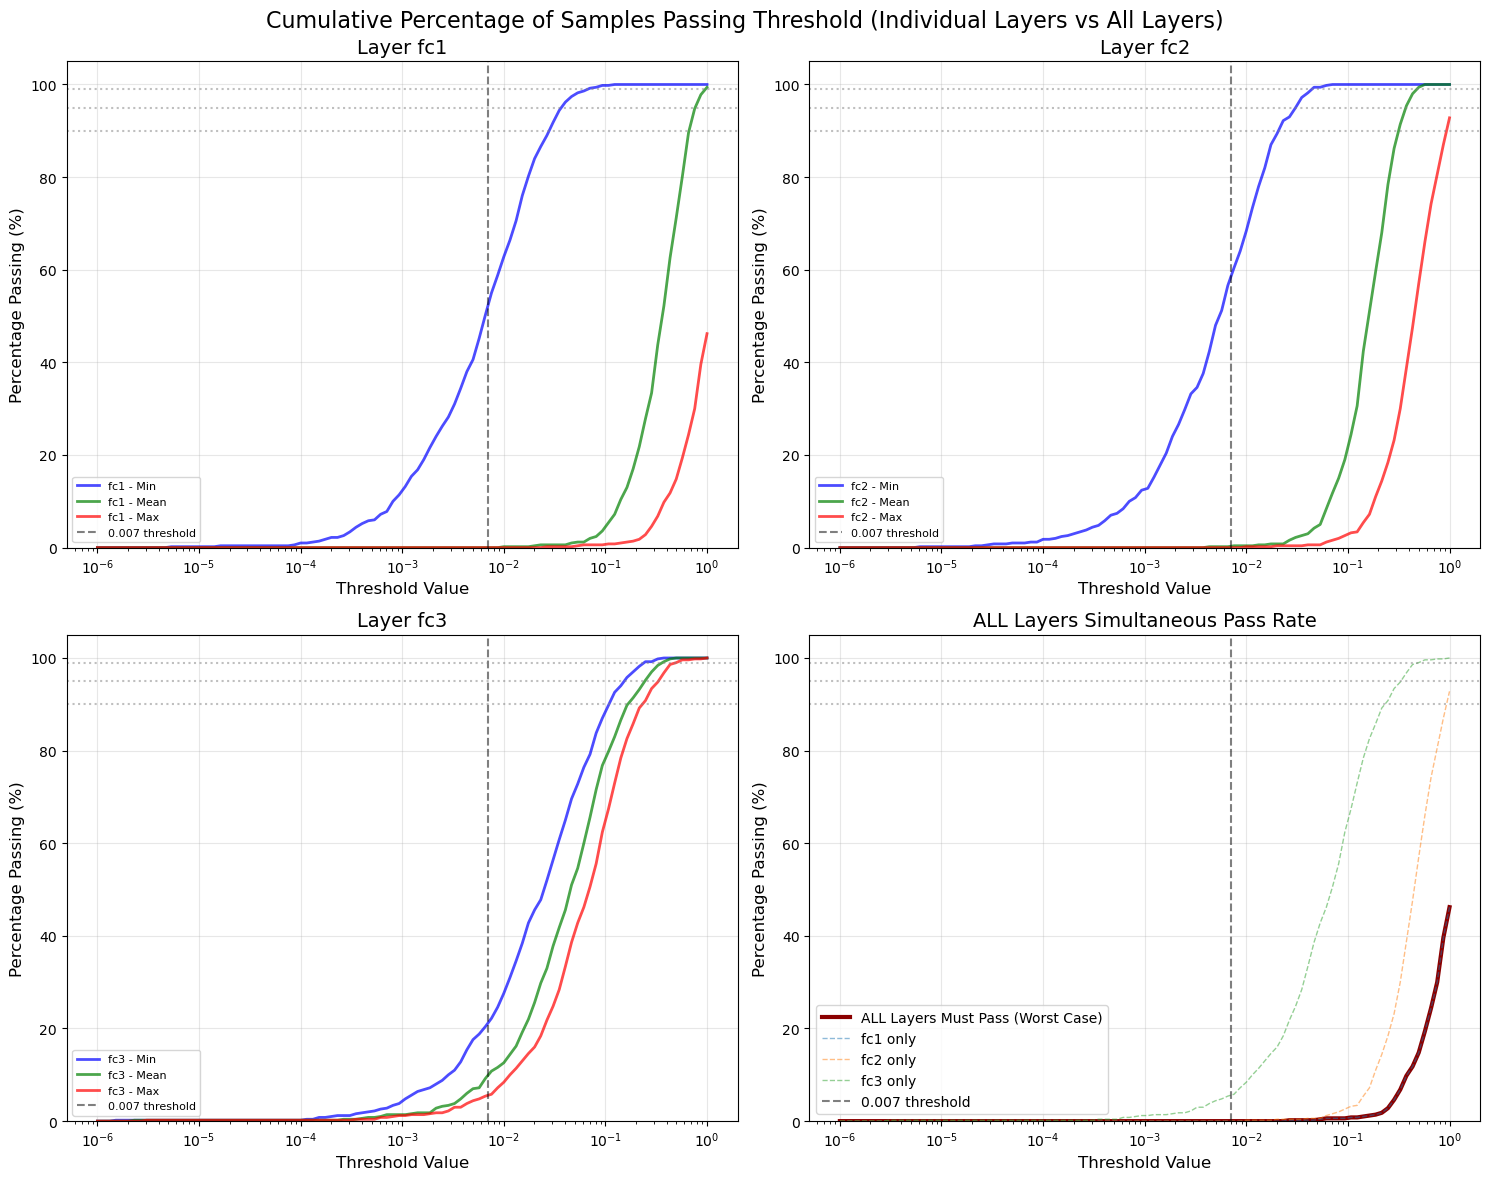


Threshold Analysis Table (Including ALL LAYERS Requirement):
     Layer  Threshold Min Pass % Mean Pass % Max Pass %
       fc1      0.001      11.6%        0.0%       0.0%
       fc1      0.005      40.8%        0.0%       0.0%
       fc1      0.007      52.4%        0.0%       0.0%
       fc1      0.010      62.8%        0.2%       0.0%
       fc1      0.050      98.0%        1.0%       0.2%
       fc1      0.100      99.8%        4.0%       0.6%
       fc2      0.001      12.8%        0.0%       0.0%
       fc2      0.005      48.0%        0.2%       0.0%
       fc2      0.007      57.6%        0.2%       0.0%
       fc2      0.010      68.4%        0.4%       0.2%
       fc2      0.050      99.4%        4.4%       0.6%
       fc2      0.100     100.0%       22.0%       2.8%
       fc3      0.001       4.0%        1.4%       1.2%
       fc3      0.005      17.6%        7.0%       4.4%
       fc3      0.007      21.0%        9.8%       5.8%
       fc3      0.010      27.6%       12.

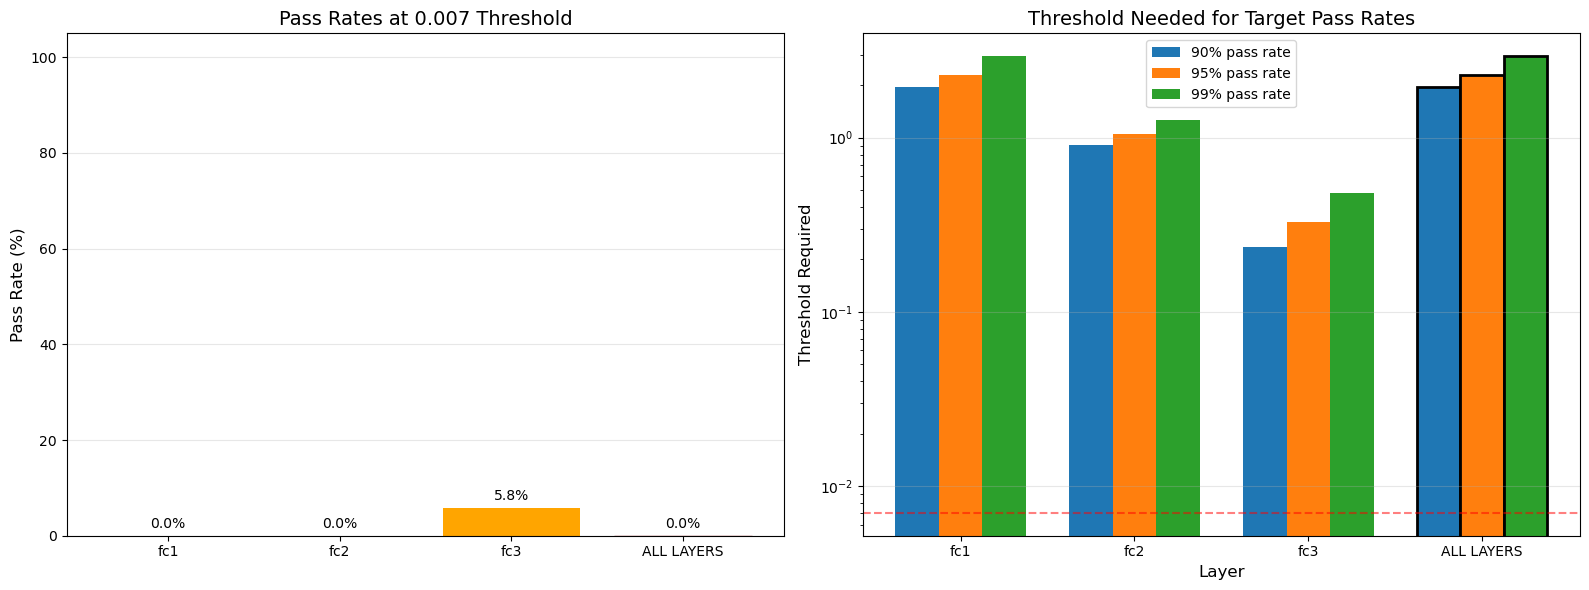

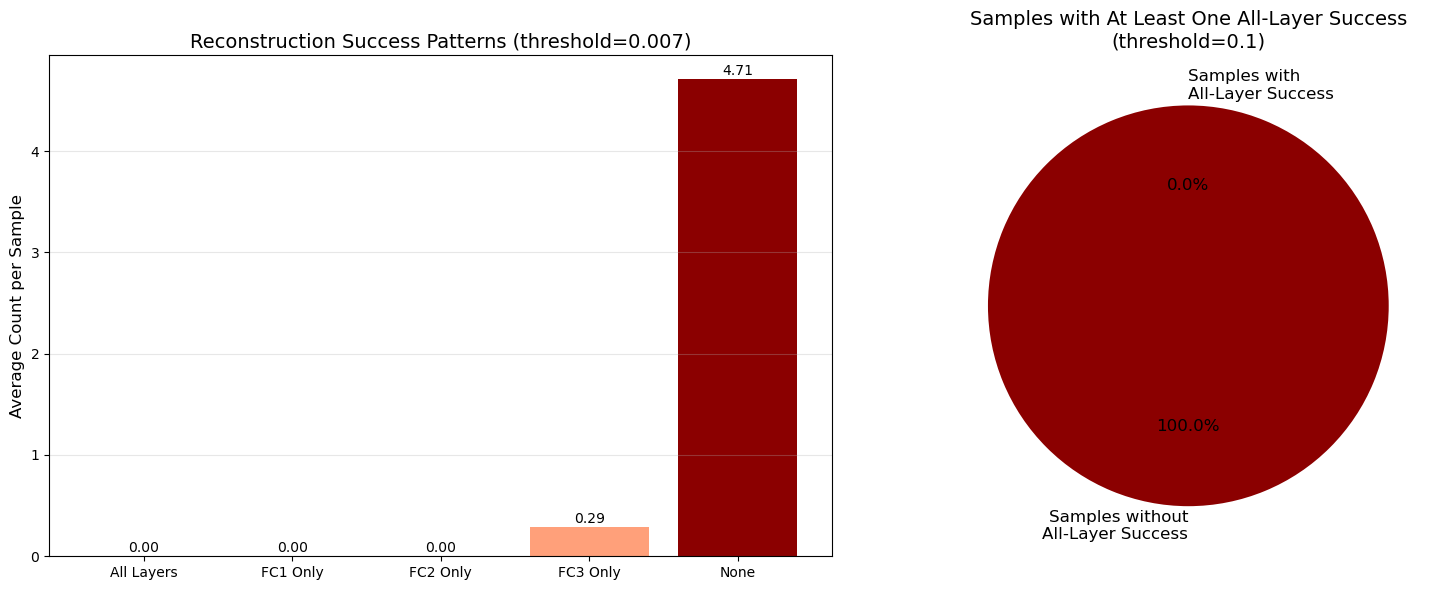


ALL LAYERS SIMULTANEOUS RECONSTRUCTION ANALYSIS

Summary Statistics for Threshold Selection (ALL LAYERS MUST PASS):
------------------------------------------------------------

Threshold needed for target pass rates:
  90% pass rate: 1.951064
  95% pass rate: 2.276078
  99% pass rate: 2.938464
  99.9% pass rate: 4.010929


Pass rates at specific thresholds:
----------------------------------------
  Threshold 0.001: 0.0% pass rate
  Threshold 0.005: 0.0% pass rate
  Threshold 0.007: 0.0% pass rate
  Threshold 0.01: 0.0% pass rate
  Threshold 0.05: 0.2% pass rate
  Threshold 0.1: 0.6% pass rate


Comparison: Individual Layer vs All Layers (at 0.007 threshold):
------------------------------------------------------------
  fc1 alone: 0.0%
  fc2 alone: 0.0%
  fc3 alone: 5.8%
  ALL layers simultaneously: 0.0%

  Reduction when requiring all layers: 100.0%


In [50]:
# %%
# Generate activation difference data with ALL LAYERS CHECK
def generate_activation_differences_all_layers(model, X_data, n_samples=100, n_reconstructions=5):
    """Generate activation differences checking if ALL layers pass threshold simultaneously"""
    
    results = []
    layers = ['fc1', 'fc2', 'fc3']
    
    for sample_idx in tqdm(range(min(n_samples, len(X_data))), desc="Processing samples"):
        original_input = X_data[sample_idx]
        
        # Get original activations
        original_activations = {}
        hooks = []
        for layer in layers:
            hooks.append(getattr(model, layer).register_forward_hook(
                get_activation(layer, original_activations)
            ))
        
        model.eval()
        with torch.no_grad():
            original_output = model(original_input.unsqueeze(0))
        
        for hook in hooks:
            hook.remove()
        
        # Multiple reconstruction attempts
        for recon_idx in range(n_reconstructions):
            # Reconstruct input
            reconstructed_input = torch.randn(1, 4, requires_grad=True)
            optimizer = optim.Adam([reconstructed_input], lr=0.01)
            
            for _ in range(500):
                optimizer.zero_grad()
                output = model(reconstructed_input)
                loss = nn.functional.mse_loss(output, original_output)
                loss.backward()
                optimizer.step()
            
            # Get reconstructed activations
            reconstructed_activations = {}
            hooks = []
            for layer in layers:
                hooks.append(getattr(model, layer).register_forward_hook(
                    get_activation(layer, reconstructed_activations)
                ))
            
            with torch.no_grad():
                _ = model(reconstructed_input)
            
            for hook in hooks:
                hook.remove()
            
            # Calculate differences for each layer
            row = {'sample_idx': sample_idx, 'reconstruction_idx': recon_idx}
            
            # Store individual layer metrics
            all_layer_max_diffs = []
            for layer in layers:
                orig_act = original_activations[layer].flatten()
                recon_act = reconstructed_activations[layer].flatten()
                
                abs_diff = torch.abs(orig_act - recon_act)
                
                row[f'{layer}_min_abs_diff'] = abs_diff.min().item()
                row[f'{layer}_mean_abs_diff'] = abs_diff.mean().item()
                row[f'{layer}_max_abs_diff'] = abs_diff.max().item()
                
                all_layer_max_diffs.append(abs_diff.max().item())
            
            # CRITICAL: Store the maximum difference across ALL layers
            row['all_layers_max_diff'] = max(all_layer_max_diffs)
            
            # Also store minimum of the maximums (best case scenario across layers)
            row['all_layers_min_of_max'] = min(all_layer_max_diffs)
            
            results.append(row)
    
    return pd.DataFrame(results)

# %%
# Generate results
print("Generating activation differences with all-layer checks...")
results = generate_activation_differences_all_layers(model, X_train, n_samples=100, n_reconstructions=5)

# Save results
results.to_csv('activation_diff_results_all_layers.csv', index=False)
print(f"Results saved. Shape: {results.shape}")

# %%
# Define threshold values to test
thresholds = np.logspace(-6, 0, 100)  # From 1e-6 to 1 (0.000001 to 1)

# Create figure for cumulative distribution INCLUDING ALL-LAYERS CHECK
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Cumulative Percentage of Samples Passing Threshold (Individual Layers vs All Layers)', fontsize=16)

layers = ['fc1', 'fc2', 'fc3']
metrics = ['min_abs_diff', 'mean_abs_diff', 'max_abs_diff']
colors = {'min_abs_diff': 'blue', 'mean_abs_diff': 'green', 'max_abs_diff': 'red'}

# Plot for each layer
for idx, layer in enumerate(layers):
    ax = axes[idx//2, idx%2]
    
    for metric in metrics:
        column = f'{layer}_{metric}'
        values = results[column].values
        
        # Calculate percentage passing each threshold
        percentages = []
        for threshold in thresholds:
            passing = np.sum(values <= threshold) / len(values) * 100
            percentages.append(passing)
        
        # Plot cumulative distribution
        ax.semilogx(thresholds, percentages, 
                   label=f'{layer} - {metric.replace("_abs_diff", "").capitalize()}',
                   color=colors[metric], linewidth=2, alpha=0.7)
    
    # Add reference lines
    ax.axvline(x=0.007, color='black', linestyle='--', alpha=0.5, label='0.007 threshold')
    ax.axhline(y=90, color='gray', linestyle=':', alpha=0.5)
    ax.axhline(y=95, color='gray', linestyle=':', alpha=0.5)
    ax.axhline(y=99, color='gray', linestyle=':', alpha=0.5)
    
    ax.set_xlabel('Threshold Value', fontsize=12)
    ax.set_ylabel('Percentage Passing (%)', fontsize=12)
    ax.set_title(f'Layer {layer}', fontsize=14)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 105)

# CRITICAL: Plot ALL LAYERS simultaneous check
ax = axes[1, 1]

# Plot the all-layers maximum (worst case - ALL must pass)
values = results['all_layers_max_diff'].values
percentages_all = []
for threshold in thresholds:
    passing = np.sum(values <= threshold) / len(values) * 100
    percentages_all.append(passing)

ax.semilogx(thresholds, percentages_all, 
           label='ALL Layers Must Pass (Worst Case)',
           color='darkred', linewidth=3)

# Also plot individual layer maximums for comparison
for layer in layers:
    values = results[f'{layer}_max_abs_diff'].values
    percentages = []
    for threshold in thresholds:
        passing = np.sum(values <= threshold) / len(values) * 100
        percentages.append(passing)
    ax.semilogx(thresholds, percentages, 
               label=f'{layer} only',
               linewidth=1, alpha=0.5, linestyle='--')

ax.axvline(x=0.007, color='black', linestyle='--', alpha=0.5, label='0.007 threshold')
ax.axhline(y=90, color='gray', linestyle=':', alpha=0.5)
ax.axhline(y=95, color='gray', linestyle=':', alpha=0.5)
ax.axhline(y=99, color='gray', linestyle=':', alpha=0.5)

ax.set_xlabel('Threshold Value', fontsize=12)
ax.set_ylabel('Percentage Passing (%)', fontsize=12)
ax.set_title('ALL Layers Simultaneous Pass Rate', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('cumulative_threshold_all_layers.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Create detailed threshold analysis table INCLUDING ALL-LAYERS
threshold_values = [0.001, 0.005, 0.007, 0.01, 0.05, 0.1]
analysis_results = []

# Individual layer analysis
for layer in layers:
    for threshold in threshold_values:
        row = {'Layer': layer, 'Threshold': threshold}
        
        for metric in metrics:
            column = f'{layer}_{metric}'
            values = results[column].values
            passing_percentage = np.sum(values <= threshold) / len(values) * 100
            row[f'{metric.replace("_abs_diff", "").capitalize()} Pass %'] = f'{passing_percentage:.1f}%'
        
        analysis_results.append(row)

# ALL LAYERS analysis
for threshold in threshold_values:
    row = {'Layer': 'ALL LAYERS', 'Threshold': threshold}
    
    # Check if ALL layers pass simultaneously
    values = results['all_layers_max_diff'].values
    passing_percentage = np.sum(values <= threshold) / len(values) * 100
    row['Min Pass %'] = '-'
    row['Mean Pass %'] = '-'
    row['Max Pass %'] = f'{passing_percentage:.1f}%'
    
    analysis_results.append(row)

# Create DataFrame and display
threshold_df = pd.DataFrame(analysis_results)
print("\nThreshold Analysis Table (Including ALL LAYERS Requirement):")
print("="*80)
print(threshold_df.to_string(index=False))

# Save to CSV
threshold_df.to_csv('threshold_analysis_all_layers.csv', index=False)

# %%
# Create comparison visualization: Individual vs All Layers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Pass rates at 0.007 threshold
threshold_007 = 0.007
pass_rates_007 = {}

for layer in layers:
    values = results[f'{layer}_max_abs_diff'].values
    pass_rates_007[layer] = np.sum(values <= threshold_007) / len(values) * 100

# All layers
values = results['all_layers_max_diff'].values
pass_rates_007['ALL LAYERS'] = np.sum(values <= threshold_007) / len(values) * 100

# Plot
keys = list(pass_rates_007.keys())
values = list(pass_rates_007.values())
bars = ax1.bar(keys, values, color=['blue', 'green', 'orange', 'darkred'])

# Color the ALL LAYERS bar differently
bars[-1].set_color('darkred')
bars[-1].set_alpha(0.8)

ax1.set_ylabel('Pass Rate (%)', fontsize=12)
ax1.set_title('Pass Rates at 0.007 Threshold', fontsize=14)
ax1.set_ylim(0, 105)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value:.1f}%', ha='center', va='bottom')

# Right plot: Threshold needed for different pass rates
target_pass_rates = [90, 95, 99]
threshold_needed = {rate: {} for rate in target_pass_rates}

for rate in target_pass_rates:
    # Individual layers
    for layer in layers:
        values = results[f'{layer}_max_abs_diff'].values
        threshold_needed[rate][layer] = np.percentile(values, rate)
    
    # All layers
    values = results['all_layers_max_diff'].values
    threshold_needed[rate]['ALL LAYERS'] = np.percentile(values, rate)

# Plot
x = np.arange(len(keys))
width = 0.25

for i, rate in enumerate(target_pass_rates):
    values = [threshold_needed[rate][k] for k in keys]
    bars = ax2.bar(x + i*width, values, width, label=f'{rate}% pass rate')
    
    # Highlight ALL LAYERS
    bars[-1].set_edgecolor('black')
    bars[-1].set_linewidth(2)

ax2.set_xlabel('Layer', fontsize=12)
ax2.set_ylabel('Threshold Required', fontsize=12)
ax2.set_title('Threshold Needed for Target Pass Rates', fontsize=14)
ax2.set_xticks(x + width)
ax2.set_xticklabels(keys)
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, axis='y')

# Add 0.007 reference line
ax2.axhline(y=0.007, color='red', linestyle='--', alpha=0.5, label='0.007 threshold')

plt.tight_layout()
plt.savefig('individual_vs_all_layers_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Analyze reconstruction success patterns
def analyze_reconstruction_patterns(results, threshold=0.007):
    """Analyze which reconstructions succeed for all layers simultaneously"""
    
    # Group by sample
    grouped = results.groupby('sample_idx')
    
    success_patterns = []
    
    for sample_idx, group in grouped:
        sample_data = {
            'sample_idx': sample_idx,
            'total_reconstructions': len(group),
            'all_layers_pass': 0,
            'fc1_only_pass': 0,
            'fc2_only_pass': 0,
            'fc3_only_pass': 0,
            'none_pass': 0
        }
        
        for _, row in group.iterrows():
            fc1_pass = row['fc1_max_abs_diff'] <= threshold
            fc2_pass = row['fc2_max_abs_diff'] <= threshold
            fc3_pass = row['fc3_max_abs_diff'] <= threshold
            all_pass = row['all_layers_max_diff'] <= threshold
            
            if all_pass:
                sample_data['all_layers_pass'] += 1
            elif fc1_pass and not fc2_pass and not fc3_pass:
                sample_data['fc1_only_pass'] += 1
            elif fc2_pass and not fc1_pass and not fc3_pass:
                sample_data['fc2_only_pass'] += 1
            elif fc3_pass and not fc1_pass and not fc2_pass:
                sample_data['fc3_only_pass'] += 1
            else:
                sample_data['none_pass'] += 1
        
        success_patterns.append(sample_data)
    
    return pd.DataFrame(success_patterns)

# %%
# Analyze patterns
pattern_df = analyze_reconstruction_patterns(results, threshold=0.007)

# Visualize patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Distribution of success types
success_types = ['all_layers_pass', 'fc1_only_pass', 'fc2_only_pass', 'fc3_only_pass', 'none_pass']
mean_counts = [pattern_df[col].mean() for col in success_types]
labels = ['All Layers', 'FC1 Only', 'FC2 Only', 'FC3 Only', 'None']

bars = ax1.bar(labels, mean_counts, color=['darkgreen', 'lightblue', 'lightgreen', 'lightsalmon', 'darkred'])
ax1.set_ylabel('Average Count per Sample', fontsize=12)
ax1.set_title('Reconstruction Success Patterns (threshold=0.007)', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, mean_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.2f}', ha='center', va='bottom')

# Right: Percentage of samples with at least one successful all-layer reconstruction
samples_with_success = (pattern_df['all_layers_pass'] > 0).sum()
total_samples = len(pattern_df)
success_percentage = samples_with_success / total_samples * 100

categories = ['Samples with\nAll-Layer Success', 'Samples without\nAll-Layer Success']
values = [samples_with_success, total_samples - samples_with_success]
colors = ['darkgreen', 'darkred']

wedges, texts, autotexts = ax2.pie(values, labels=categories, colors=colors, autopct='%1.1f%%',
                                    startangle=90, textprops={'fontsize': 12})
ax2.set_title(f'Samples with At Least One All-Layer Success\n(threshold={threshold})', fontsize=14)

plt.tight_layout()
plt.savefig('reconstruction_success_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Summary statistics for ALL LAYERS requirement
print("\n" + "="*80)
print("ALL LAYERS SIMULTANEOUS RECONSTRUCTION ANALYSIS")
print("="*80)

print("\nSummary Statistics for Threshold Selection (ALL LAYERS MUST PASS):")
print("-"*60)

values = results['all_layers_max_diff'].values

# Find threshold for different pass rates
pass_rates = [90, 95, 99, 99.9]
print("\nThreshold needed for target pass rates:")

for rate in pass_rates:
    threshold_for_rate = np.percentile(values, rate)
    print(f"  {rate}% pass rate: {threshold_for_rate:.6f}")

# Statistics at specific thresholds
print("\n\nPass rates at specific thresholds:")
print("-"*40)

for threshold in threshold_values:
    pass_rate = np.sum(values <= threshold) / len(values) * 100
    print(f"  Threshold {threshold}: {pass_rate:.1f}% pass rate")

# Compare with individual layers
print("\n\nComparison: Individual Layer vs All Layers (at 0.007 threshold):")
print("-"*60)

for layer in layers:
    individual_values = results[f'{layer}_max_abs_diff'].values
    individual_pass_rate = np.sum(individual_values <= 0.007) / len(individual_values) * 100
    print(f"  {layer} alone: {individual_pass_rate:.1f}%")

all_layers_pass_rate = np.sum(values <= 0.007) / len(values) * 100
print(f"  ALL layers simultaneously: {all_layers_pass_rate:.1f}%")

reduction = 100 - (all_layers_pass_rate / np.mean([np.sum(results[f'{layer}_max_abs_diff'].values <= 0.007) / len(results) * 100 for layer in layers]) * 100)
print(f"\n  Reduction when requiring all layers: {reduction:.1f}%")